In [1]:
# Import needed libraries
%reload_ext tensorboard

import datetime

# Data containers
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

import gensim
from gensim.models import Word2Vec

# Machine Learning Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import MultinomialNB

# Deep_Learning
import tensorflow as tf
from tensorflow import keras

# This code snippet forces tensorflow to not automatically allocate all GPU ram which can be an issue in notebook environment
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.disable_traceback_filtering()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Braden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Braden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Braden\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Braden\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1 Physical GPUs, 1 Logical GPUs


### Define the Custom Layer for multiple activation functions per layer

In [2]:
# Define custom Layer
class MultiActivationLayer(keras.layers.Layer):
    '''
    Multiple Activation Layer
    
    A neural network layer in which every node has a different activation function applied
    '''
    
    def __init__(self, out_features, activations, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.activations = activations
    
    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.out_features]), name='w')
        self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
    
    @tf.function
    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b
        shape = tf.shape(z)[0]
        
        # Apply activation function to ouput features from nodes (columns) separately with different activation functions
        #, reshape to 2-D array and concatenate the results from each node in the same order
        nodes = [tf.reshape(self.activations[i%len(self.activations)](z[:,i]), (shape, 1)) for i in range(self.out_features)]
        z = tf.concat(nodes, 1)
        return z
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "out_features": self.out_features,
            "activations": self.activations,
        })
        return config

## Define method for creating the testing models with equivalent architectures

In [3]:
# Define custom architecture using the new layer
def create_model(activations, option='multi', num_classes=1, dropout=False, dropout_rate=0.2, task='classification'):
    if option == 'uniform':
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
                ])
            else:
                 return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(1, name='layers_dense')
                ])
        else:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
                ])
            else:
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(1, name='layers_dense')
                ])
    elif option == 'multi':
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    MultiActivationLayer(25, activations, name='layers_multi_1'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(20, activations, name='layers_multi_2'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(15, activations, name='layers_multi_3'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(10, activations, name='layers_multi_4'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(5, activations, name='layers_multi_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
                ])
            else:
                 return keras.models.Sequential([
                    MultiActivationLayer(25, activations, name='layers_multi_1'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(20, activations, name='layers_multi_2'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(15, activations, name='layers_multi_3'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(10, activations, name='layers_multi_4'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(5, activations, name='layers_multi_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(1, name='layers_dense')
                ])
        else:
            if task == 'classification':
                return keras.models.Sequential([
                    MultiActivationLayer(25, activations, name='layers_multi_1'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(20, activations, name='layers_multi_2'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(15, activations, name='layers_multi_3'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(10, activations, name='layers_multi_4'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(5, activations, name='layers_multi_5'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
                ])
            else:
                return keras.models.Sequential([
                    MultiActivationLayer(25, activations, name='layers_multi_1'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(20, activations, name='layers_multi_2'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(15, activations, name='layers_multi_3'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(10, activations, name='layers_multi_4'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(5, activations, name='layers_multi_5'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(1, name='layers_dense')
                ])
    elif option == 'sequential':
        if len(activations) < 5: raise RuntimeError()
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
                ])
            else:
                 return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(1, name='layers_dense')
                ])
        else: 
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
                ])
            else:
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                    keras.layers.Dropout(dropout_rate),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(1, name='layers_dense')
                ])
    else:
        raise RuntimeError()

## Define method for training all testing models on the data

In [4]:
# Define testing function for generating and running tests
def test(X, y, num_classes=None, X_test=None, y_test=None, task='classification', epochs=100, batch_size=32, task_name=''):
    
    MANN, MANN_drop, UANN1, UANN2, UANN3, UANN4, UANN5, SANN = None, None, None, None, None, None, None, None
    
    if X_test is None or y_test is None:
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    else:
        X_train, y_train = X, y

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(1000).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
        
    
    if task == 'classification':
        if num_classes is None:
            raise RuntimeError()
            
        if task_name == 'NLP':
            vectorization_layer = keras.layers.TextVectorization(output_sequence_length=15000)
            vectorization_layer.adapt(X_train)
    
        # Create our model
        MANN = create_model(activations=[tf.nn.sigmoid, tf.nn.tanh, tf.nn.leaky_relu, tf.nn.elu, tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in MANN.layers:
                model.add(layer)
            MANN = model
        MANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])

        # Create our model with dropout
        MANN_drop = create_model(activations=[tf.nn.sigmoid, tf.nn.tanh, tf.nn.leaky_relu, tf.nn.elu, tf.nn.swish], dropout=True, num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in MANN_drop.layers:
                model.add(layer)
            MANN_drop = model
        MANN_drop.compile(optimizer=keras.optimizers.legacy.Nadam(),
                         loss=keras.losses.CategoricalCrossentropy(),
                         metrics=[keras.metrics.CategoricalAccuracy()])

        # Create uniform model for each activation function
        UANN1 = create_model(activations=[tf.nn.sigmoid], option='uniform', num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in UANN1.layers:
                model.add(layer)
            UANN1 = model
        UANN1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN2 = create_model(activations=[tf.nn.tanh], option='uniform', num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in UANN2.layers:
                model.add(layer)
            UANN2 = model
        UANN2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN3 = create_model(activations=[tf.nn.leaky_relu], option='uniform', num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in UANN3.layers:
                model.add(layer)
            UANN3 = model
        UANN3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN4 = create_model(activations=[tf.nn.elu], option='uniform', num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in UANN4.layers:
                model.add(layer)
            UANN4 = model
        UANN4.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN5 = create_model(activations=[tf.nn.swish], option='uniform', num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in UANN5.layers:
                model.add(layer)
            UANN5 = model
        UANN5.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        # Create sequential activation network
        SANN = create_model(activations=[tf.nn.swish, tf.nn.elu, tf.nn.leaky_relu, tf.nn.tanh, tf.nn.sigmoid], option='sequential', dropout=False, num_classes=num_classes, task=task)
        if task_name == 'NLP':
            model = keras.Sequential()
            model.add(keras.Input(shape=(1,), dtype=tf.string))
            model.add(vectorization_layer)
            model.add(keras.layers.Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=50))
            model.add(keras.layers.Flatten())
            for layer in SANN.layers:
                model.add(layer)
            SANN = model
        SANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
    elif task == 'regression':
        # Create our model
        MANN = create_model(activations=[tf.nn.sigmoid, tf.nn.tanh, tf.nn.leaky_relu, tf.nn.elu, tf.nn.swish], dropout=False, task=task)
        MANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())

        # Create our model with dropout
        MANN_drop = create_model(activations=[tf.nn.sigmoid, tf.nn.tanh, tf.nn.leaky_relu, tf.nn.elu, tf.nn.swish], dropout=True, task=task)
        MANN_drop.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
        
        # Create uniform model for each activation function
        UANN1 = create_model(activations=[tf.nn.sigmoid], option='uniform', task=task)
        UANN1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
        
        UANN2 = create_model(activations=[tf.nn.tanh], option='uniform', task=task)
        UANN2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
        
        UANN3 = create_model(activations=[tf.nn.leaky_relu], option='uniform', task=task)
        UANN3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
        
        UANN4 = create_model(activations=[tf.nn.elu], option='uniform', task=task)
        UANN4.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
        
        UANN5 = create_model(activations=[tf.nn.swish], option='uniform', task=task)
        UANN5.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
        
        # Create sequential activation network
        SANN = create_model(activations=[tf.nn.swish, tf.nn.elu, tf.nn.leaky_relu, tf.nn.tanh, tf.nn.sigmoid], option='sequential', task=task)
        SANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.MeanSquaredError())
    else:
        raise RuntimeError()
    
    # Fit the data to the models for a set number of epochs
    print("Training Multi Activation Neural Network...")
    path=f'{task_name}.MANN.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    MANN_hist = MANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('')

    print("Training Multi Activation Neural Network w/ Dropout...")
    path=f'{task_name}.MANN_dropout.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    MANN_drop_hist = MANN_drop.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')


    print("Training Sigmoid Uniform Activation Neural Network...")
    path=f'{task_name}.Sigmoid.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN1_hist = UANN1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')

    print("Training Tanh Uniform Activation Neural Network...")
    path=f'{task_name}.Tanh.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN2_hist = UANN2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')

    print("Training Leaky ReLU Uniform Activation Neural Network...")
    path=f'{task_name}.LeakyReLU.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN3_hist = UANN3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')

    print("Training ELU Uniform Activation Neural Network...")
    path=f'{task_name}.ELU.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN4_hist = UANN4.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')

    print("Training Swish Uniform Activation Neural Network...")
    path=f'{task_name}.Swish.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN5_hist = UANN5.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')

    print("Training Sequential Activation Neural Network...")
    path=f'{task_name}.Sequential.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    SANN_hist = SANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    print('Finished.')

    # Create dictionaries to return for models and scores
    models = {
        'MANN': MANN,
        'MANN_Dropout': MANN_drop,
        'Sigmoid': UANN1,
        'Tanh': UANN2,
        'LeakyReLU': UANN3,
        'ELU': UANN4,
        'Swish': UANN5,
        'Sequential': SANN
    }
    
    histories = {
        'MANN': MANN_hist,
        'MANN_dropout': MANN_drop_hist,
        'Sigmoid': UANN1_hist,
        'Tanh': UANN2_hist,
        'LeakyReLU': UANN3_hist,
        'ELU': UANN4_hist,
        'Swish': UANN5_hist,
        'Sequential': SANN_hist
    }

    return models, histories

## Regression task

In [88]:
# Load the data and split into testing and training for processing
data = pd.read_csv('./Datasets/Regression/train.csv')
features = data.drop('TARGET(PRICE_IN_LACS)', axis=1)
target = data['TARGET(PRICE_IN_LACS)']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [89]:
data.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


In [90]:
data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [91]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['POSTED_BY', 'BHK_OR_RK']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['POSTED_BY', 'BHK_OR_RK']]), columns=one_hot.get_feature_names_out()))

# Drop the transformed columns and unneeded columns
X_train.drop(['POSTED_BY', 'BHK_OR_RK', 'ADDRESS'], axis = 1, inplace=True)
X_test.drop(['POSTED_BY', 'BHK_OR_RK', 'ADDRESS'], axis=1, inplace=True)

# Normalize numerical columns
scaler = StandardScaler()
X_train[['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']]= scaler.fit_transform(X_train[['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']])
X_test[['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']] = scaler.transform(X_test[['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']])

C:\Users\Braden\AppData\Local\Temp\ipykernel_26904\3635932901.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['POSTED_BY', 'BHK_OR_RK']]), columns=one_hot.get_feature_names_out()))
C:\Users\Braden\AppData\Local\Temp\ipykernel_26904\3635932901.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['POSTED_BY', 'BHK_OR_RK']]), columns=one_hot.get_feature_names_out()))


In [92]:
X_test.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE
21992,0,0,0.684258,-0.007035,1,1,0.192071,1.098189
29060,0,0,0.684258,-0.006865,1,1,1.150735,0.025204
6778,0,0,-0.444198,-0.007191,1,1,1.179616,0.050227
4730,0,0,0.684258,-0.006587,1,1,0.529079,-0.298616
28825,1,0,-0.444198,-0.007128,0,1,0.226822,1.101250


In [10]:
# Create and fit all neural networks for evaluations
models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), task='regression', epochs=500, batch_size=128, task_name='Regression')

Training Multi Activation Neural Network...
Epoch 1/500
185/185 [==============================] - 5s 14ms/step - loss: 423427.3125 - val_loss: 564641.1250
Epoch 2/500
185/185 [==============================] - 2s 12ms/step - loss: 422645.6875 - val_loss: 563635.8750
Epoch 3/500
185/185 [==============================] - 2s 12ms/step - loss: 421426.8125 - val_loss: 562573.6875
Epoch 4/500
185/185 [==============================] - 2s 12ms/step - loss: 419603.7188 - val_loss: 561218.3750
Epoch 5/500
185/185 [==============================] - 2s 12ms/step - loss: 417275.2188 - val_loss: 558726.3125
Epoch 6/500
185/185 [==============================] - 2s 12ms/step - loss: 414859.5312 - val_loss: 555996.1875
Epoch 7/500
185/185 [==============================] - 2s 12ms/step - loss: 412485.7188 - val_loss: 553492.8750
Epoch 8/500
185/185 [==============================] - 2s 12ms/step - loss: 409847.8750 - val_loss: 551916.7500
Epoch 9/500
185/185 [==============================] - 2s 12

185/185 [==============================] - 2s 13ms/step - loss: 59128.2383 - val_loss: 480541.8438
Epoch 146/500
185/185 [==============================] - 2s 12ms/step - loss: 65309.8633 - val_loss: 491143.0625
Epoch 147/500
185/185 [==============================] - 2s 12ms/step - loss: 58619.7891 - val_loss: 447345.0625
Epoch 148/500
185/185 [==============================] - 2s 13ms/step - loss: 61983.5000 - val_loss: 436483.6562
Epoch 149/500
185/185 [==============================] - 2s 12ms/step - loss: 59951.3984 - val_loss: 444821.7188
Epoch 150/500
185/185 [==============================] - 2s 12ms/step - loss: 59781.6719 - val_loss: 383834.3438
Epoch 151/500
185/185 [==============================] - 2s 12ms/step - loss: 67542.0859 - val_loss: 431895.8438
Epoch 152/500
185/185 [==============================] - 2s 11ms/step - loss: 68028.1172 - val_loss: 591669.2500
Epoch 153/500
185/185 [==============================] - 2s 11ms/step - loss: 59754.3867 - val_loss: 594006.81

185/185 [==============================] - 2s 10ms/step - loss: 50291.7422 - val_loss: 259486.5312
Epoch 290/500
185/185 [==============================] - 2s 10ms/step - loss: 49423.2539 - val_loss: 406668.8125
Epoch 291/500
185/185 [==============================] - 2s 10ms/step - loss: 43377.8047 - val_loss: 339292.4375
Epoch 292/500
185/185 [==============================] - 2s 10ms/step - loss: 48749.1328 - val_loss: 283783.1562
Epoch 293/500
185/185 [==============================] - 2s 10ms/step - loss: 46692.9258 - val_loss: 312741.6875
Epoch 294/500
185/185 [==============================] - 2s 10ms/step - loss: 43408.1758 - val_loss: 408070.1250
Epoch 295/500
185/185 [==============================] - 2s 10ms/step - loss: 47267.7656 - val_loss: 274216.9062
Epoch 296/500
185/185 [==============================] - 2s 10ms/step - loss: 50955.2578 - val_loss: 295305.3750
Epoch 297/500
185/185 [==============================] - 2s 11ms/step - loss: 56684.7930 - val_loss: 251819.51

Epoch 434/500
185/185 [==============================] - 2s 10ms/step - loss: 39336.0352 - val_loss: 98082.5547
Epoch 435/500
185/185 [==============================] - 2s 10ms/step - loss: 36070.7383 - val_loss: 123752.0234
Epoch 436/500
185/185 [==============================] - 2s 10ms/step - loss: 39510.7188 - val_loss: 107198.2109
Epoch 437/500
185/185 [==============================] - 2s 10ms/step - loss: 40799.8906 - val_loss: 169756.9844
Epoch 438/500
185/185 [==============================] - 2s 10ms/step - loss: 39900.8125 - val_loss: 111768.8984
Epoch 439/500
185/185 [==============================] - 2s 10ms/step - loss: 37687.0898 - val_loss: 95693.6484
Epoch 440/500
185/185 [==============================] - 2s 10ms/step - loss: 36541.0859 - val_loss: 84565.0469
Epoch 441/500
185/185 [==============================] - 2s 10ms/step - loss: 35997.7148 - val_loss: 93169.6562
Epoch 442/500
185/185 [==============================] - 2s 10ms/step - loss: 38564.4492 - val_loss:

185/185 [==============================] - 2s 10ms/step - loss: 356987.4375 - val_loss: 509630.5000
Epoch 79/500
185/185 [==============================] - 2s 10ms/step - loss: 362936.9375 - val_loss: 501078.3438
Epoch 80/500
185/185 [==============================] - 2s 11ms/step - loss: 362606.2812 - val_loss: 493375.8438
Epoch 81/500
185/185 [==============================] - 2s 10ms/step - loss: 356809.3125 - val_loss: 506282.7500
Epoch 82/500
185/185 [==============================] - 2s 11ms/step - loss: 358633.0000 - val_loss: 507635.5312
Epoch 83/500
185/185 [==============================] - 2s 11ms/step - loss: 359918.2812 - val_loss: 505611.9062
Epoch 84/500
185/185 [==============================] - 2s 11ms/step - loss: 352109.5000 - val_loss: 490158.7500
Epoch 85/500
185/185 [==============================] - 2s 11ms/step - loss: 349955.1562 - val_loss: 500816.7500
Epoch 86/500
185/185 [==============================] - 2s 10ms/step - loss: 354261.3750 - val_loss: 497337.1

Epoch 222/500
185/185 [==============================] - 2s 11ms/step - loss: 187372.5469 - val_loss: 389339.0938
Epoch 223/500
185/185 [==============================] - 2s 11ms/step - loss: 176572.7812 - val_loss: 397963.0312
Epoch 224/500
185/185 [==============================] - 2s 11ms/step - loss: 182567.0781 - val_loss: 396936.0625
Epoch 225/500
185/185 [==============================] - 2s 10ms/step - loss: 208043.9375 - val_loss: 389601.6562
Epoch 226/500
185/185 [==============================] - 2s 10ms/step - loss: 183484.3438 - val_loss: 419839.5938
Epoch 227/500
185/185 [==============================] - 2s 12ms/step - loss: 179619.5469 - val_loss: 397200.0938
Epoch 228/500
185/185 [==============================] - 2s 10ms/step - loss: 157648.8906 - val_loss: 399140.9062
Epoch 229/500
185/185 [==============================] - 2s 10ms/step - loss: 197863.1562 - val_loss: 373669.0000
Epoch 230/500
185/185 [==============================] - 2s 11ms/step - loss: 196335.640

Epoch 294/500
185/185 [==============================] - 2s 10ms/step - loss: 171419.0938 - val_loss: 384833.5000
Epoch 295/500
185/185 [==============================] - 2s 10ms/step - loss: 147361.6406 - val_loss: 396465.3125
Epoch 296/500
185/185 [==============================] - 2s 10ms/step - loss: 158483.5156 - val_loss: 365217.2812
Epoch 297/500
185/185 [==============================] - 2s 10ms/step - loss: 174646.0000 - val_loss: 366067.6562
Epoch 298/500
185/185 [==============================] - 2s 10ms/step - loss: 160723.7188 - val_loss: 352045.0625
Epoch 299/500
185/185 [==============================] - 2s 10ms/step - loss: 159597.3594 - val_loss: 383151.8750
Epoch 300/500
185/185 [==============================] - 2s 10ms/step - loss: 152532.5625 - val_loss: 393118.3438
Epoch 301/500
185/185 [==============================] - 2s 10ms/step - loss: 164385.7344 - val_loss: 382852.0938
Epoch 302/500
185/185 [==============================] - 2s 10ms/step - loss: 178261.140

Epoch 366/500
185/185 [==============================] - 2s 10ms/step - loss: 159554.9062 - val_loss: 332192.7500
Epoch 367/500
185/185 [==============================] - 2s 10ms/step - loss: 122088.7891 - val_loss: 331561.3125
Epoch 368/500
185/185 [==============================] - 2s 10ms/step - loss: 162219.7656 - val_loss: 322056.9062
Epoch 369/500
185/185 [==============================] - 2s 10ms/step - loss: 151475.8750 - val_loss: 341388.0625
Epoch 370/500
185/185 [==============================] - 2s 10ms/step - loss: 128571.3047 - val_loss: 327792.7188
Epoch 371/500
185/185 [==============================] - 2s 11ms/step - loss: 154469.2656 - val_loss: 326057.4062
Epoch 372/500
185/185 [==============================] - 2s 10ms/step - loss: 138802.1094 - val_loss: 331171.1250
Epoch 373/500
185/185 [==============================] - 2s 10ms/step - loss: 162338.9219 - val_loss: 326423.1250
Epoch 374/500
185/185 [==============================] - 2s 10ms/step - loss: 148467.750

Epoch 438/500
185/185 [==============================] - 2s 12ms/step - loss: 161458.9688 - val_loss: 401358.2500
Epoch 439/500
185/185 [==============================] - 2s 11ms/step - loss: 139902.6094 - val_loss: 335025.2812
Epoch 440/500
185/185 [==============================] - 2s 11ms/step - loss: 144231.0625 - val_loss: 336972.7500
Epoch 441/500
185/185 [==============================] - 2s 11ms/step - loss: 149774.2812 - val_loss: 316890.0625
Epoch 442/500
185/185 [==============================] - 2s 11ms/step - loss: 145645.1719 - val_loss: 308568.9062
Epoch 443/500
185/185 [==============================] - 2s 11ms/step - loss: 142728.6094 - val_loss: 306587.4062
Epoch 444/500
185/185 [==============================] - 2s 11ms/step - loss: 141170.0312 - val_loss: 336198.6250
Epoch 445/500
185/185 [==============================] - 2s 11ms/step - loss: 161359.9219 - val_loss: 308281.6875
Epoch 446/500
185/185 [==============================] - 2s 11ms/step - loss: 141442.406

185/185 [==============================] - 1s 7ms/step - loss: 112739.9844 - val_loss: 196227.7656
Epoch 83/500
185/185 [==============================] - 1s 7ms/step - loss: 113363.3750 - val_loss: 196239.7500
Epoch 84/500
185/185 [==============================] - 1s 7ms/step - loss: 102408.4609 - val_loss: 194610.1875
Epoch 85/500
185/185 [==============================] - 1s 7ms/step - loss: 112417.6328 - val_loss: 191246.7812
Epoch 86/500
185/185 [==============================] - 1s 7ms/step - loss: 99881.3047 - val_loss: 181374.5781
Epoch 87/500
185/185 [==============================] - 1s 7ms/step - loss: 97990.2891 - val_loss: 180702.1406
Epoch 88/500
185/185 [==============================] - 1s 7ms/step - loss: 98726.4531 - val_loss: 169524.1875
Epoch 89/500
185/185 [==============================] - 1s 7ms/step - loss: 102438.7266 - val_loss: 273317.7500
Epoch 90/500
185/185 [==============================] - 1s 7ms/step - loss: 105935.6562 - val_loss: 171297.2812
Epoch 91

185/185 [==============================] - 1s 7ms/step - loss: 66396.1406 - val_loss: 129167.1016
Epoch 229/500
185/185 [==============================] - 1s 7ms/step - loss: 61649.7422 - val_loss: 127613.5156
Epoch 230/500
185/185 [==============================] - 1s 7ms/step - loss: 60686.1094 - val_loss: 124132.1484
Epoch 231/500
185/185 [==============================] - 1s 6ms/step - loss: 47266.6719 - val_loss: 125185.4141
Epoch 232/500
185/185 [==============================] - 1s 6ms/step - loss: 52922.2422 - val_loss: 127292.6016
Epoch 233/500
185/185 [==============================] - 1s 7ms/step - loss: 51286.8555 - val_loss: 126199.3828
Epoch 234/500
185/185 [==============================] - 1s 6ms/step - loss: 49535.5430 - val_loss: 124824.4453
Epoch 235/500
185/185 [==============================] - 1s 6ms/step - loss: 46810.5781 - val_loss: 126059.3672
Epoch 236/500
185/185 [==============================] - 1s 6ms/step - loss: 52561.8867 - val_loss: 125641.5078
Epoch 

185/185 [==============================] - 1s 7ms/step - loss: 39320.3477 - val_loss: 129886.5078
Epoch 375/500
185/185 [==============================] - 1s 7ms/step - loss: 39813.7305 - val_loss: 133820.0781
Epoch 376/500
185/185 [==============================] - 1s 7ms/step - loss: 42087.0977 - val_loss: 133542.9844
Epoch 377/500
185/185 [==============================] - 1s 7ms/step - loss: 37041.8398 - val_loss: 133610.4844
Epoch 378/500
185/185 [==============================] - 1s 7ms/step - loss: 38183.8242 - val_loss: 138412.8438
Epoch 379/500
185/185 [==============================] - 1s 7ms/step - loss: 37582.3203 - val_loss: 138957.3281
Epoch 380/500
185/185 [==============================] - 1s 7ms/step - loss: 41620.5117 - val_loss: 132050.6250
Epoch 381/500
185/185 [==============================] - 1s 7ms/step - loss: 39724.8633 - val_loss: 138881.0781
Epoch 382/500
185/185 [==============================] - 1s 7ms/step - loss: 36039.2852 - val_loss: 146147.2656
Epoch 

Epoch 20/500
185/185 [==============================] - 1s 7ms/step - loss: 341527.4688 - val_loss: 461086.8125
Epoch 21/500
185/185 [==============================] - 1s 7ms/step - loss: 332146.0312 - val_loss: 451350.1250
Epoch 22/500
185/185 [==============================] - 1s 7ms/step - loss: 325553.0938 - val_loss: 446342.1875
Epoch 23/500
185/185 [==============================] - 1s 7ms/step - loss: 321073.6875 - val_loss: 440674.7812
Epoch 24/500
185/185 [==============================] - 1s 7ms/step - loss: 319272.2188 - val_loss: 451781.1562
Epoch 25/500
185/185 [==============================] - 1s 7ms/step - loss: 312120.1562 - val_loss: 427239.2812
Epoch 26/500
185/185 [==============================] - 1s 7ms/step - loss: 311528.6250 - val_loss: 415036.4062
Epoch 27/500
185/185 [==============================] - 1s 7ms/step - loss: 300377.4062 - val_loss: 406774.7812
Epoch 28/500
185/185 [==============================] - 1s 7ms/step - loss: 296549.3438 - val_loss: 4015

185/185 [==============================] - 1s 7ms/step - loss: 56510.9727 - val_loss: 264454.2812
Epoch 167/500
185/185 [==============================] - 1s 7ms/step - loss: 46231.2422 - val_loss: 237444.2812
Epoch 168/500
185/185 [==============================] - 1s 7ms/step - loss: 59207.2695 - val_loss: 273247.9375
Epoch 169/500
185/185 [==============================] - 1s 7ms/step - loss: 63996.2344 - val_loss: 224671.8750
Epoch 170/500
185/185 [==============================] - 1s 7ms/step - loss: 52842.3281 - val_loss: 238698.7969
Epoch 171/500
185/185 [==============================] - 1s 7ms/step - loss: 47521.4766 - val_loss: 244401.2188
Epoch 172/500
185/185 [==============================] - 1s 7ms/step - loss: 43722.8047 - val_loss: 247742.5312
Epoch 173/500
185/185 [==============================] - 1s 7ms/step - loss: 49998.5508 - val_loss: 246466.4688
Epoch 174/500
185/185 [==============================] - 1s 7ms/step - loss: 49147.9180 - val_loss: 221366.8438
Epoch 

185/185 [==============================] - 1s 7ms/step - loss: 37816.6641 - val_loss: 281049.9375
Epoch 313/500
185/185 [==============================] - 1s 7ms/step - loss: 35288.5859 - val_loss: 282839.1250
Epoch 314/500
185/185 [==============================] - 1s 7ms/step - loss: 40816.3086 - val_loss: 277122.9688
Epoch 315/500
185/185 [==============================] - 1s 7ms/step - loss: 36321.3867 - val_loss: 278467.6562
Epoch 316/500
185/185 [==============================] - 1s 6ms/step - loss: 39314.3047 - val_loss: 284795.5000
Epoch 317/500
185/185 [==============================] - 1s 6ms/step - loss: 33687.5156 - val_loss: 277703.0625
Epoch 318/500
185/185 [==============================] - 1s 6ms/step - loss: 35265.6992 - val_loss: 287302.7812
Epoch 319/500
185/185 [==============================] - 1s 7ms/step - loss: 49036.9375 - val_loss: 538931.6875
Epoch 320/500
185/185 [==============================] - 1s 7ms/step - loss: 33352.3398 - val_loss: 280131.5938
Epoch 

185/185 [==============================] - 1s 7ms/step - loss: 30417.6113 - val_loss: 262384.3438
Epoch 459/500
185/185 [==============================] - 1s 7ms/step - loss: 29225.1562 - val_loss: 103353.2422
Epoch 460/500
185/185 [==============================] - 1s 7ms/step - loss: 30007.3652 - val_loss: 256914.6406
Epoch 461/500
185/185 [==============================] - 1s 7ms/step - loss: 36642.5469 - val_loss: 199726.1094
Epoch 462/500
185/185 [==============================] - 1s 7ms/step - loss: 32056.7637 - val_loss: 125635.0938
Epoch 463/500
185/185 [==============================] - 1s 7ms/step - loss: 33283.4102 - val_loss: 122300.8359
Epoch 464/500
185/185 [==============================] - 1s 6ms/step - loss: 32086.6191 - val_loss: 89857.7188
Epoch 465/500
185/185 [==============================] - 1s 7ms/step - loss: 33507.5469 - val_loss: 109431.0156
Epoch 466/500
185/185 [==============================] - 1s 7ms/step - loss: 30067.6445 - val_loss: 60991.3555
Epoch 46

185/185 [==============================] - 1s 7ms/step - loss: 67839.0469 - val_loss: 1899293.3750
Epoch 104/500
185/185 [==============================] - 1s 7ms/step - loss: 67117.3828 - val_loss: 2184486.0000
Epoch 105/500
185/185 [==============================] - 1s 7ms/step - loss: 69950.6328 - val_loss: 1214378.5000
Epoch 106/500
185/185 [==============================] - 1s 7ms/step - loss: 68422.7656 - val_loss: 872907.4375
Epoch 107/500
185/185 [==============================] - 1s 7ms/step - loss: 65942.4141 - val_loss: 714239.6250
Epoch 108/500
185/185 [==============================] - 1s 6ms/step - loss: 63599.6758 - val_loss: 641787.3750
Epoch 109/500
185/185 [==============================] - 1s 7ms/step - loss: 64616.1055 - val_loss: 572479.2500
Epoch 110/500
185/185 [==============================] - 1s 7ms/step - loss: 64106.0273 - val_loss: 1050013.5000
Epoch 111/500
185/185 [==============================] - 1s 6ms/step - loss: 68452.8438 - val_loss: 695564.5625
Ep

Epoch 176/500
185/185 [==============================] - 1s 7ms/step - loss: 52212.3242 - val_loss: 1708694.7500
Epoch 177/500
185/185 [==============================] - 1s 7ms/step - loss: 47049.4102 - val_loss: 1063806.0000
Epoch 178/500
185/185 [==============================] - 1s 7ms/step - loss: 49100.8633 - val_loss: 1337993.3750
Epoch 179/500
185/185 [==============================] - 1s 7ms/step - loss: 53344.6641 - val_loss: 1567043.3750
Epoch 180/500
185/185 [==============================] - 1s 7ms/step - loss: 52158.2344 - val_loss: 1798710.8750
Epoch 181/500
185/185 [==============================] - 1s 7ms/step - loss: 52322.2148 - val_loss: 770551.9375
Epoch 182/500
185/185 [==============================] - 1s 7ms/step - loss: 51910.9414 - val_loss: 1278201.8750
Epoch 183/500
185/185 [==============================] - 1s 7ms/step - loss: 51938.6367 - val_loss: 1198554.2500
Epoch 184/500
185/185 [==============================] - 1s 7ms/step - loss: 47138.7695 - val_los

185/185 [==============================] - 1s 8ms/step - loss: 44441.4141 - val_loss: 500363.5000
Epoch 322/500
185/185 [==============================] - 1s 7ms/step - loss: 38937.1797 - val_loss: 625797.5625
Epoch 323/500
185/185 [==============================] - 1s 7ms/step - loss: 39506.3867 - val_loss: 530415.6250
Epoch 324/500
185/185 [==============================] - 1s 7ms/step - loss: 43840.2266 - val_loss: 589637.6875
Epoch 325/500
185/185 [==============================] - 1s 7ms/step - loss: 41831.0820 - val_loss: 2165921.5000
Epoch 326/500
185/185 [==============================] - 1s 7ms/step - loss: 38810.2266 - val_loss: 874334.6875
Epoch 327/500
185/185 [==============================] - 1s 7ms/step - loss: 38225.4453 - val_loss: 434113.6875
Epoch 328/500
185/185 [==============================] - 1s 7ms/step - loss: 37329.1328 - val_loss: 403690.3125
Epoch 329/500
185/185 [==============================] - 1s 7ms/step - loss: 37240.3672 - val_loss: 497894.1875
Epoch

185/185 [==============================] - 1s 6ms/step - loss: 34333.2070 - val_loss: 444149.6562
Epoch 468/500
185/185 [==============================] - 1s 6ms/step - loss: 42015.9062 - val_loss: 597528.0000
Epoch 469/500
185/185 [==============================] - 1s 6ms/step - loss: 45651.4219 - val_loss: 930099.3125
Epoch 470/500
185/185 [==============================] - 1s 6ms/step - loss: 35519.9336 - val_loss: 371805.9062
Epoch 471/500
185/185 [==============================] - 1s 7ms/step - loss: 34837.4258 - val_loss: 394163.1250
Epoch 472/500
185/185 [==============================] - 1s 7ms/step - loss: 34761.6523 - val_loss: 596368.0625
Epoch 473/500
185/185 [==============================] - 1s 7ms/step - loss: 34223.2461 - val_loss: 629725.0000
Epoch 474/500
185/185 [==============================] - 1s 7ms/step - loss: 34913.8945 - val_loss: 415627.7500
Epoch 475/500
185/185 [==============================] - 1s 7ms/step - loss: 37617.5508 - val_loss: 434381.1562
Epoch 

185/185 [==============================] - 1s 7ms/step - loss: 68582.7969 - val_loss: 2317187.2500
Epoch 113/500
185/185 [==============================] - 1s 7ms/step - loss: 62989.1484 - val_loss: 2161053.7500
Epoch 114/500
185/185 [==============================] - 1s 7ms/step - loss: 64445.9531 - val_loss: 2414482.0000
Epoch 115/500
185/185 [==============================] - 1s 7ms/step - loss: 57914.1289 - val_loss: 1929844.0000
Epoch 116/500
185/185 [==============================] - 1s 7ms/step - loss: 64541.2031 - val_loss: 4161435.2500
Epoch 117/500
185/185 [==============================] - 1s 7ms/step - loss: 59710.8086 - val_loss: 1605693.0000
Epoch 118/500
185/185 [==============================] - 1s 7ms/step - loss: 62074.8594 - val_loss: 1201319.6250
Epoch 119/500
185/185 [==============================] - 1s 7ms/step - loss: 72166.6250 - val_loss: 2068051.0000
Epoch 120/500
185/185 [==============================] - 1s 7ms/step - loss: 68230.1641 - val_loss: 2314819.00

185/185 [==============================] - 1s 7ms/step - loss: 44807.7656 - val_loss: 3400666.0000
Epoch 257/500
185/185 [==============================] - 1s 7ms/step - loss: 46271.4766 - val_loss: 2752419.5000
Epoch 258/500
185/185 [==============================] - 1s 7ms/step - loss: 45286.2344 - val_loss: 2843159.7500
Epoch 259/500
185/185 [==============================] - 1s 7ms/step - loss: 45082.0273 - val_loss: 3823692.5000
Epoch 260/500
185/185 [==============================] - 1s 7ms/step - loss: 73470.9219 - val_loss: 4317915.0000
Epoch 261/500
185/185 [==============================] - 1s 7ms/step - loss: 57539.6953 - val_loss: 2983802.7500
Epoch 262/500
185/185 [==============================] - 1s 7ms/step - loss: 44301.0508 - val_loss: 2476685.2500
Epoch 263/500
185/185 [==============================] - 1s 6ms/step - loss: 45668.7695 - val_loss: 1879976.6250
Epoch 264/500
185/185 [==============================] - 1s 7ms/step - loss: 47316.7383 - val_loss: 1698749.75

185/185 [==============================] - 1s 7ms/step - loss: 40053.1875 - val_loss: 4648089.0000
Epoch 401/500
185/185 [==============================] - 1s 7ms/step - loss: 38549.5156 - val_loss: 5749893.5000
Epoch 402/500
185/185 [==============================] - 1s 7ms/step - loss: 36437.2344 - val_loss: 6644018.0000
Epoch 403/500
185/185 [==============================] - 1s 7ms/step - loss: 36326.0859 - val_loss: 5977281.0000
Epoch 404/500
185/185 [==============================] - 1s 7ms/step - loss: 36209.7188 - val_loss: 7025062.0000
Epoch 405/500
185/185 [==============================] - 1s 7ms/step - loss: 42212.3672 - val_loss: 5956575.5000
Epoch 406/500
185/185 [==============================] - 1s 7ms/step - loss: 39762.8594 - val_loss: 5884649.0000
Epoch 407/500
185/185 [==============================] - 1s 7ms/step - loss: 38530.5781 - val_loss: 6229532.0000
Epoch 408/500
185/185 [==============================] - 1s 7ms/step - loss: 38517.7109 - val_loss: 5876523.00

185/185 [==============================] - 1s 7ms/step - loss: 233562.8438 - val_loss: 224172.1875
Epoch 45/500
185/185 [==============================] - 1s 7ms/step - loss: 225666.0156 - val_loss: 166824.7656
Epoch 46/500
185/185 [==============================] - 1s 7ms/step - loss: 220246.7969 - val_loss: 184934.0156
Epoch 47/500
185/185 [==============================] - 1s 7ms/step - loss: 217535.5469 - val_loss: 161143.7344
Epoch 48/500
185/185 [==============================] - 1s 7ms/step - loss: 210591.1875 - val_loss: 168983.7812
Epoch 49/500
185/185 [==============================] - 1s 7ms/step - loss: 210133.3125 - val_loss: 174148.9531
Epoch 50/500
185/185 [==============================] - 1s 8ms/step - loss: 198926.4531 - val_loss: 156176.4844
Epoch 51/500
185/185 [==============================] - 1s 7ms/step - loss: 200356.6250 - val_loss: 162037.9062
Epoch 52/500
185/185 [==============================] - 1s 7ms/step - loss: 197102.2812 - val_loss: 204265.1562
Epoch

185/185 [==============================] - 1s 7ms/step - loss: 44605.1406 - val_loss: 538912.8125
Epoch 191/500
185/185 [==============================] - 1s 7ms/step - loss: 41904.6172 - val_loss: 353188.5312
Epoch 192/500
185/185 [==============================] - 1s 7ms/step - loss: 44230.9805 - val_loss: 345214.1250
Epoch 193/500
185/185 [==============================] - 1s 7ms/step - loss: 42441.8242 - val_loss: 350756.2188
Epoch 194/500
185/185 [==============================] - 1s 7ms/step - loss: 49531.0508 - val_loss: 330686.7812
Epoch 195/500
185/185 [==============================] - 1s 7ms/step - loss: 43209.2188 - val_loss: 220619.6719
Epoch 196/500
185/185 [==============================] - 1s 7ms/step - loss: 43832.6523 - val_loss: 1180679.5000
Epoch 197/500
185/185 [==============================] - 1s 7ms/step - loss: 43653.0898 - val_loss: 1197560.7500
Epoch 198/500
185/185 [==============================] - 1s 7ms/step - loss: 40004.2344 - val_loss: 1150387.3750
Epo

185/185 [==============================] - 1s 7ms/step - loss: 32276.5234 - val_loss: 1314434.5000
Epoch 337/500
185/185 [==============================] - 1s 7ms/step - loss: 34300.5039 - val_loss: 1081669.7500
Epoch 338/500
185/185 [==============================] - 1s 7ms/step - loss: 32258.2656 - val_loss: 980950.1250
Epoch 339/500
185/185 [==============================] - 1s 7ms/step - loss: 32940.1367 - val_loss: 1104878.7500
Epoch 340/500
185/185 [==============================] - 1s 7ms/step - loss: 33825.4023 - val_loss: 1263542.5000
Epoch 341/500
185/185 [==============================] - 1s 7ms/step - loss: 32444.8809 - val_loss: 1359979.5000
Epoch 342/500
185/185 [==============================] - 1s 7ms/step - loss: 33882.5820 - val_loss: 1232777.2500
Epoch 343/500
185/185 [==============================] - 1s 7ms/step - loss: 32759.7754 - val_loss: 1000800.4375
Epoch 344/500
185/185 [==============================] - 1s 7ms/step - loss: 31775.6152 - val_loss: 1118165.625

Epoch 409/500
185/185 [==============================] - 1s 7ms/step - loss: 31956.4785 - val_loss: 1628354.1250
Epoch 410/500
185/185 [==============================] - 1s 7ms/step - loss: 30362.0293 - val_loss: 1354397.7500
Epoch 411/500
185/185 [==============================] - 1s 7ms/step - loss: 27550.7344 - val_loss: 1570765.1250
Epoch 412/500
185/185 [==============================] - 1s 7ms/step - loss: 31385.9258 - val_loss: 1173308.1250
Epoch 413/500
185/185 [==============================] - 1s 7ms/step - loss: 29018.0625 - val_loss: 1005488.1875
Epoch 414/500
185/185 [==============================] - 1s 7ms/step - loss: 30953.8125 - val_loss: 1320867.1250
Epoch 415/500
185/185 [==============================] - 1s 7ms/step - loss: 30886.5762 - val_loss: 1014674.8125
Epoch 416/500
185/185 [==============================] - 1s 7ms/step - loss: 28432.4180 - val_loss: 985709.9375
Epoch 417/500
185/185 [==============================] - 1s 7ms/step - loss: 33095.6016 - val_los

185/185 [==============================] - 1s 7ms/step - loss: 190456.8281 - val_loss: 289637.0000
Epoch 54/500
185/185 [==============================] - 1s 7ms/step - loss: 187497.3281 - val_loss: 287891.4688
Epoch 55/500
185/185 [==============================] - 1s 7ms/step - loss: 182580.7188 - val_loss: 286760.9375
Epoch 56/500
185/185 [==============================] - 1s 7ms/step - loss: 176687.7188 - val_loss: 356329.5625
Epoch 57/500
185/185 [==============================] - 1s 7ms/step - loss: 175956.1094 - val_loss: 399420.7188
Epoch 58/500
185/185 [==============================] - 1s 7ms/step - loss: 179501.4688 - val_loss: 357242.1875
Epoch 59/500
185/185 [==============================] - 1s 7ms/step - loss: 172562.4219 - val_loss: 330049.3125
Epoch 60/500
185/185 [==============================] - 1s 7ms/step - loss: 167319.8906 - val_loss: 461832.6875
Epoch 61/500
185/185 [==============================] - 1s 6ms/step - loss: 160281.4531 - val_loss: 387103.2500
Epoch

185/185 [==============================] - 1s 7ms/step - loss: 59003.3008 - val_loss: 458657.3125
Epoch 200/500
185/185 [==============================] - 1s 7ms/step - loss: 86959.4375 - val_loss: 243775.9688
Epoch 201/500
185/185 [==============================] - 1s 6ms/step - loss: 62913.9883 - val_loss: 156150.8438
Epoch 202/500
185/185 [==============================] - 1s 7ms/step - loss: 64034.0117 - val_loss: 140434.2344
Epoch 203/500
185/185 [==============================] - 1s 7ms/step - loss: 55797.0469 - val_loss: 139063.9062
Epoch 204/500
185/185 [==============================] - 1s 7ms/step - loss: 61243.4375 - val_loss: 137604.7344
Epoch 205/500
185/185 [==============================] - 1s 7ms/step - loss: 64213.0859 - val_loss: 155099.3594
Epoch 206/500
185/185 [==============================] - 1s 6ms/step - loss: 62244.1602 - val_loss: 159099.8125
Epoch 207/500
185/185 [==============================] - 1s 6ms/step - loss: 64708.5000 - val_loss: 180263.7031
Epoch 

185/185 [==============================] - 1s 7ms/step - loss: 58696.5586 - val_loss: 347976.6875
Epoch 346/500
185/185 [==============================] - 1s 7ms/step - loss: 53949.8984 - val_loss: 578759.2500
Epoch 347/500
185/185 [==============================] - 1s 7ms/step - loss: 58788.3945 - val_loss: 320190.1875
Epoch 348/500
185/185 [==============================] - 1s 7ms/step - loss: 52932.9062 - val_loss: 311360.1562
Epoch 349/500
185/185 [==============================] - 1s 7ms/step - loss: 53691.3203 - val_loss: 317941.0000
Epoch 350/500
185/185 [==============================] - 1s 7ms/step - loss: 55243.0273 - val_loss: 304639.4062
Epoch 351/500
185/185 [==============================] - 1s 7ms/step - loss: 51815.5625 - val_loss: 519727.8750
Epoch 352/500
185/185 [==============================] - 1s 7ms/step - loss: 59370.4141 - val_loss: 318576.3750
Epoch 353/500
185/185 [==============================] - 1s 7ms/step - loss: 54436.5430 - val_loss: 343582.3438
Epoch 

185/185 [==============================] - 1s 7ms/step - loss: 44179.9375 - val_loss: 367107.8125
Epoch 492/500
185/185 [==============================] - 1s 7ms/step - loss: 43407.2305 - val_loss: 719546.0000
Epoch 493/500
185/185 [==============================] - 1s 7ms/step - loss: 46690.8477 - val_loss: 267897.4375
Epoch 494/500
185/185 [==============================] - 1s 6ms/step - loss: 43071.9062 - val_loss: 377111.4375
Epoch 495/500
185/185 [==============================] - 1s 6ms/step - loss: 38965.3750 - val_loss: 353244.5938
Epoch 496/500
185/185 [==============================] - 1s 6ms/step - loss: 38708.0430 - val_loss: 376106.5000
Epoch 497/500
185/185 [==============================] - 1s 7ms/step - loss: 39130.1055 - val_loss: 395517.4062
Epoch 498/500
185/185 [==============================] - 1s 7ms/step - loss: 38810.8047 - val_loss: 300814.5625
Epoch 499/500
185/185 [==============================] - 1s 7ms/step - loss: 38365.6875 - val_loss: 274825.2188
Epoch 

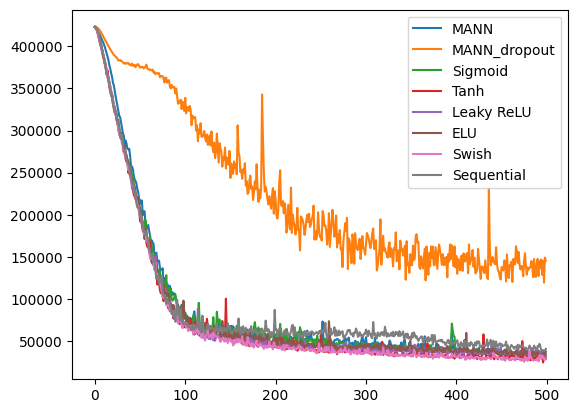

In [11]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')
plt.plot(np.array(range(len(histories['MANN_dropout'].history['loss']))), histories['MANN_dropout'].history['loss'], label='MANN_dropout')
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')
plt.legend()
plt.show()

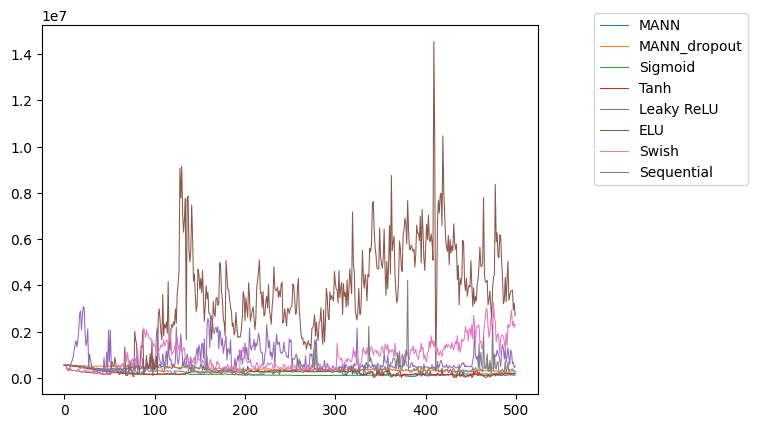

In [12]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_dropout'].history['loss']))), histories['MANN_dropout'].history['val_loss'], label='MANN_dropout', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [13]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Regression.training_hist.csv')
val_hist_df.to_csv('Regression.validation_hist.csv')

In [93]:
# Load the best performing weights for each model and fit the traditional ML models
for name, model in models.items():
    model.load_weights(f'Regression.{name}.tf')

# Traditional models as a baseline comparison
linreg = LinearRegression()
linreg.fit(X_train, y_train)

svm = LinearSVR(max_iter=10000)
svm.fit(X_train, y_train)

LinearSVR(max_iter=10000)

In [104]:
# Get the testing loss for each model
linreg_loss = keras.losses.mean_squared_error(y_test.to_numpy(), linreg.predict(X_test)).numpy()
svm_loss = keras.losses.mean_squared_error(y_test.to_numpy(), svm.predict(X_test)).numpy()
MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
MANN_dropout_loss = models['MANN_Dropout'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']
Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['loss']

185/185 [==============================] - 0s 2ms/step - loss: 137604.7500


In [106]:
# Save testing loss to table and display results
results = pd.DataFrame([linreg_loss, svm_loss, MANN_loss, MANN_dropout_loss, Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['Linear Regression', 'Support Vector Machine', 'MANN', 'MANN w/ Dropout', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Mean Squared Error'])
results.sort_values('Mean Squared Error', inplace=True)
results.head(10)

,Mean Squared Error
Tanh NN,26422.431641
MANN,65544.984375
ELU NN,65653.312500
Sigmoid NN,109276.750000
Sequential NN,137604.750000
Swish NN,156176.484375
MANN w/ Dropout,223829.562500
Leaky ReLU NN,261046.968750
Linear Regression,326164.614714
Support Vector Machine,361163.442891


## NLP task

In [5]:
# Load the data and split into testing and training for processing
data = pd.read_csv('./Datasets/NLP/twitter_MBTI.csv', index_col=0)
features = data['text']
target = data['label']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42, stratify=target)

In [6]:
data.describe()

,text,label
count,7811,7811
unique,7581,16
top,I just realize that today is dzi's birthday......,infp
freq,2,1282


In [7]:
data.head(100)

,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
...,...,...
95,Doing my project on isle neumann|||@fuzy_sox I...,entp
96,she gets it https://t.co/tK0PlXKO2d|||@nakopoc...,entp
97,@WeezingOffline @Max__4__x @raptalksk @Hemant3...,entp
98,Thanks to @About1816 for inviting me to write ...,entp


In [8]:
def wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatize(document):
    word_pos_tags = nltk.pos_tag(document)
    roots = [lemmatizer.lemmatize(tag[0], wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return roots

In [9]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)
lemmatizer = WordNetLemmatizer()
#vectorizer = TfidfVectorizer(max_features=5000)

# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

# Clean and process text
X_train = X_train.map(lambda x: x.lower().strip())
X_test = X_test.map(lambda x: x.lower().strip())

X_train = X_train.map(lambda x: [token for y in x.split('|||') for token in y.split(' ') if 'http' not in token and '@' not in token])
X_test = X_test.map(lambda x: [token for y in x.split('|||') for token in y.split(' ') if 'http' not in token and '@' not in token])

X_train = X_train.map(lambda x: ' '.join(x))
X_test = X_test.map(lambda x: ' '.join(x))

X_train = X_train.map(word_tokenize)
X_test = X_test.map(word_tokenize)

X_train = X_train.map(lambda x: [word for word in x if word not in stop_words and word.isalpha()])
X_test = X_test.map(lambda x: [word for word in x if word not in stop_words and word.isalpha()])

X_train = X_train.map(lambda x: lemmatize(x))
X_test = X_test.map(lambda x: lemmatize(x))

X_train = X_train.map(lambda x: ' '.join(x))
X_test = X_test.map(lambda x: ' '.join(x))

# Create word embeddings with TF-IDF
#X_train = vectorizer.fit_transform(X_train)
#X_test = vectorizer.transform(X_test)

#X_train = np.asarray(X_train.todense())
#X_test = np.asarray(X_test.todense())

In [22]:
# Create and fit all neural networks for evaluations
models, histories = test(X_train, y_train.to_numpy(), X_test=X_test, y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=500, batch_size=128, task_name='NLP')

Training Multi Activation Neural Network...
Epoch 1/500
49/49 [==============================] - 5s 64ms/step - loss: 2.9257 - categorical_accuracy: 0.0482 - val_loss: 5.9992 - val_categorical_accuracy: 0.0128
Epoch 2/500
49/49 [==============================] - 3s 60ms/step - loss: 2.6086 - categorical_accuracy: 0.1271 - val_loss: 4.2651 - val_categorical_accuracy: 0.0128
Epoch 3/500
49/49 [==============================] - 3s 61ms/step - loss: 2.3998 - categorical_accuracy: 0.2510 - val_loss: 3.5062 - val_categorical_accuracy: 0.0128
Epoch 4/500
49/49 [==============================] - 3s 61ms/step - loss: 2.2496 - categorical_accuracy: 0.3244 - val_loss: 2.8920 - val_categorical_accuracy: 0.0819
Epoch 5/500
49/49 [==============================] - 3s 61ms/step - loss: 2.0678 - categorical_accuracy: 0.3865 - val_loss: 2.8113 - val_categorical_accuracy: 0.1472
Epoch 6/500
49/49 [==============================] - 2s 49ms/step - loss: 2.0584 - categorical_accuracy: 0.3694 - val_loss: 3.

Epoch 50/500
49/49 [==============================] - 2s 49ms/step - loss: 0.2094 - categorical_accuracy: 0.9483 - val_loss: 10.4363 - val_categorical_accuracy: 0.0755
Epoch 51/500
49/49 [==============================] - 2s 48ms/step - loss: 0.2087 - categorical_accuracy: 0.9465 - val_loss: 10.2685 - val_categorical_accuracy: 0.0832
Epoch 52/500
49/49 [==============================] - 2s 49ms/step - loss: 0.1979 - categorical_accuracy: 0.9518 - val_loss: 10.0954 - val_categorical_accuracy: 0.0774
Epoch 53/500
49/49 [==============================] - 2s 48ms/step - loss: 0.1947 - categorical_accuracy: 0.9485 - val_loss: 8.8520 - val_categorical_accuracy: 0.0787
Epoch 54/500
49/49 [==============================] - 2s 49ms/step - loss: 0.1948 - categorical_accuracy: 0.9501 - val_loss: 7.1081 - val_categorical_accuracy: 0.0749
Epoch 55/500
49/49 [==============================] - 2s 49ms/step - loss: 0.1901 - categorical_accuracy: 0.9515 - val_loss: 10.1045 - val_categorical_accuracy: 0

49/49 [==============================] - 2s 50ms/step - loss: 0.0894 - categorical_accuracy: 0.9810 - val_loss: 7.4763 - val_categorical_accuracy: 0.1324
Epoch 100/500
49/49 [==============================] - 2s 50ms/step - loss: 0.0914 - categorical_accuracy: 0.9803 - val_loss: 7.0832 - val_categorical_accuracy: 0.1324
Epoch 101/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0923 - categorical_accuracy: 0.9795 - val_loss: 7.5807 - val_categorical_accuracy: 0.1248
Epoch 102/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0921 - categorical_accuracy: 0.9787 - val_loss: 7.3197 - val_categorical_accuracy: 0.1235
Epoch 103/500
49/49 [==============================] - 2s 50ms/step - loss: 0.0999 - categorical_accuracy: 0.9773 - val_loss: 7.2247 - val_categorical_accuracy: 0.1344
Epoch 104/500
49/49 [==============================] - 2s 50ms/step - loss: 0.0814 - categorical_accuracy: 0.9813 - val_loss: 7.7568 - val_categorical_accuracy: 0.1184
Epoch 

Epoch 148/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0539 - categorical_accuracy: 0.9880 - val_loss: 9.8688 - val_categorical_accuracy: 0.1683
Epoch 149/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0515 - categorical_accuracy: 0.9888 - val_loss: 13.1794 - val_categorical_accuracy: 0.0461
Epoch 150/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0519 - categorical_accuracy: 0.9878 - val_loss: 8.4939 - val_categorical_accuracy: 0.1164
Epoch 151/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0503 - categorical_accuracy: 0.9894 - val_loss: 9.1001 - val_categorical_accuracy: 0.1593
Epoch 152/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0494 - categorical_accuracy: 0.9883 - val_loss: 10.9079 - val_categorical_accuracy: 0.1753
Epoch 153/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0578 - categorical_accuracy: 0.9870 - val_loss: 11.1947 - val_categorical_accura

Epoch 197/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0387 - categorical_accuracy: 0.9925 - val_loss: 10.1853 - val_categorical_accuracy: 0.1337
Epoch 198/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0327 - categorical_accuracy: 0.9923 - val_loss: 8.4827 - val_categorical_accuracy: 0.1452
Epoch 199/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0325 - categorical_accuracy: 0.9920 - val_loss: 10.0352 - val_categorical_accuracy: 0.1164
Epoch 200/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0338 - categorical_accuracy: 0.9925 - val_loss: 9.4239 - val_categorical_accuracy: 0.1209
Epoch 201/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0352 - categorical_accuracy: 0.9930 - val_loss: 9.1895 - val_categorical_accuracy: 0.1350
Epoch 202/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0332 - categorical_accuracy: 0.9918 - val_loss: 9.5009 - val_categorical_accurac

49/49 [==============================] - 2s 48ms/step - loss: 0.0232 - categorical_accuracy: 0.9947 - val_loss: 12.2988 - val_categorical_accuracy: 0.1171
Epoch 294/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0222 - categorical_accuracy: 0.9950 - val_loss: 12.1733 - val_categorical_accuracy: 0.1254
Epoch 295/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0266 - categorical_accuracy: 0.9934 - val_loss: 9.8880 - val_categorical_accuracy: 0.1267
Epoch 296/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0227 - categorical_accuracy: 0.9965 - val_loss: 11.6588 - val_categorical_accuracy: 0.1235
Epoch 297/500
49/49 [==============================] - 2s 50ms/step - loss: 0.0198 - categorical_accuracy: 0.9955 - val_loss: 10.2167 - val_categorical_accuracy: 0.1107
Epoch 298/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0230 - categorical_accuracy: 0.9957 - val_loss: 9.8526 - val_categorical_accuracy: 0.1190
Ep

49/49 [==============================] - 2s 49ms/step - loss: 0.0085 - categorical_accuracy: 0.9981 - val_loss: 11.3553 - val_categorical_accuracy: 0.1459
Epoch 390/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0063 - categorical_accuracy: 0.9987 - val_loss: 11.2069 - val_categorical_accuracy: 0.1350
Epoch 391/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0072 - categorical_accuracy: 0.9981 - val_loss: 15.3620 - val_categorical_accuracy: 0.0870
Epoch 392/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0083 - categorical_accuracy: 0.9981 - val_loss: 13.8240 - val_categorical_accuracy: 0.1088
Epoch 393/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0085 - categorical_accuracy: 0.9989 - val_loss: 12.1506 - val_categorical_accuracy: 0.0992
Epoch 394/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0103 - categorical_accuracy: 0.9976 - val_loss: 11.1678 - val_categorical_accuracy: 0.1248


49/49 [==============================] - 2s 49ms/step - loss: 0.0078 - categorical_accuracy: 0.9976 - val_loss: 13.4984 - val_categorical_accuracy: 0.1081
Epoch 486/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0092 - categorical_accuracy: 0.9981 - val_loss: 12.6728 - val_categorical_accuracy: 0.1356
Epoch 487/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0094 - categorical_accuracy: 0.9970 - val_loss: 15.5394 - val_categorical_accuracy: 0.1094
Epoch 488/500
49/49 [==============================] - 2s 49ms/step - loss: 0.0097 - categorical_accuracy: 0.9971 - val_loss: 23.6640 - val_categorical_accuracy: 0.1011
Epoch 489/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0090 - categorical_accuracy: 0.9979 - val_loss: 15.6920 - val_categorical_accuracy: 0.0896
Epoch 490/500
49/49 [==============================] - 2s 48ms/step - loss: 0.0047 - categorical_accuracy: 0.9990 - val_loss: 11.3776 - val_categorical_accuracy: 0.1408


Epoch 34/500
49/49 [==============================] - 2s 49ms/step - loss: 1.9729 - categorical_accuracy: 0.3110 - val_loss: 2.9096 - val_categorical_accuracy: 0.1484
Epoch 35/500
49/49 [==============================] - 2s 49ms/step - loss: 1.9455 - categorical_accuracy: 0.3283 - val_loss: 2.9084 - val_categorical_accuracy: 0.1510
Epoch 36/500
49/49 [==============================] - 2s 49ms/step - loss: 1.9375 - categorical_accuracy: 0.3279 - val_loss: 2.9231 - val_categorical_accuracy: 0.1536
Epoch 37/500
49/49 [==============================] - 2s 49ms/step - loss: 1.9230 - categorical_accuracy: 0.3334 - val_loss: 2.7554 - val_categorical_accuracy: 0.1536
Epoch 38/500
49/49 [==============================] - 2s 49ms/step - loss: 1.9035 - categorical_accuracy: 0.3339 - val_loss: 2.9309 - val_categorical_accuracy: 0.1510
Epoch 39/500
49/49 [==============================] - 2s 49ms/step - loss: 1.8941 - categorical_accuracy: 0.3411 - val_loss: 2.8770 - val_categorical_accuracy: 0.150

49/49 [==============================] - 2s 49ms/step - loss: 1.7542 - categorical_accuracy: 0.3916 - val_loss: 4.6103 - val_categorical_accuracy: 0.1132
Epoch 84/500
49/49 [==============================] - 2s 49ms/step - loss: 1.6712 - categorical_accuracy: 0.4088 - val_loss: 3.8417 - val_categorical_accuracy: 0.1452
Epoch 85/500
49/49 [==============================] - 2s 49ms/step - loss: 1.6473 - categorical_accuracy: 0.4179 - val_loss: 3.9446 - val_categorical_accuracy: 0.1459
Epoch 86/500
49/49 [==============================] - 2s 49ms/step - loss: 1.6134 - categorical_accuracy: 0.4262 - val_loss: 3.5918 - val_categorical_accuracy: 0.1484
Epoch 87/500
49/49 [==============================] - 2s 49ms/step - loss: 1.6428 - categorical_accuracy: 0.4161 - val_loss: 4.2427 - val_categorical_accuracy: 0.1721
Epoch 88/500
49/49 [==============================] - 2s 49ms/step - loss: 1.6265 - categorical_accuracy: 0.4211 - val_loss: 3.6634 - val_categorical_accuracy: 0.1536
Epoch 89/50

Epoch 132/500
49/49 [==============================] - 2s 48ms/step - loss: 1.3677 - categorical_accuracy: 0.4890 - val_loss: 3.9472 - val_categorical_accuracy: 0.1587
Epoch 133/500
49/49 [==============================] - 2s 48ms/step - loss: 1.3608 - categorical_accuracy: 0.4930 - val_loss: 3.8922 - val_categorical_accuracy: 0.1536
Epoch 134/500
49/49 [==============================] - 2s 49ms/step - loss: 1.3452 - categorical_accuracy: 0.4962 - val_loss: 4.1952 - val_categorical_accuracy: 0.1536
Epoch 135/500
49/49 [==============================] - 2s 49ms/step - loss: 1.3463 - categorical_accuracy: 0.4949 - val_loss: 4.0662 - val_categorical_accuracy: 0.1504
Epoch 136/500
49/49 [==============================] - 2s 49ms/step - loss: 1.3456 - categorical_accuracy: 0.4973 - val_loss: 4.0443 - val_categorical_accuracy: 0.1644
Epoch 137/500
49/49 [==============================] - 2s 49ms/step - loss: 1.3535 - categorical_accuracy: 0.4958 - val_loss: 3.9997 - val_categorical_accuracy:

Epoch 181/500
49/49 [==============================] - 2s 49ms/step - loss: 1.2101 - categorical_accuracy: 0.5448 - val_loss: 4.1183 - val_categorical_accuracy: 0.1478
Epoch 182/500
49/49 [==============================] - 2s 49ms/step - loss: 1.2168 - categorical_accuracy: 0.5424 - val_loss: 4.3741 - val_categorical_accuracy: 0.1638
Epoch 183/500
49/49 [==============================] - 2s 49ms/step - loss: 1.1867 - categorical_accuracy: 0.5480 - val_loss: 4.3725 - val_categorical_accuracy: 0.1465
Epoch 184/500
49/49 [==============================] - 2s 49ms/step - loss: 1.1882 - categorical_accuracy: 0.5488 - val_loss: 4.3259 - val_categorical_accuracy: 0.1484
Epoch 185/500
49/49 [==============================] - 2s 49ms/step - loss: 1.1946 - categorical_accuracy: 0.5405 - val_loss: 4.5241 - val_categorical_accuracy: 0.1337
Epoch 186/500
49/49 [==============================] - 2s 49ms/step - loss: 1.2114 - categorical_accuracy: 0.5459 - val_loss: 4.2194 - val_categorical_accuracy:

Epoch 230/500
49/49 [==============================] - 2s 50ms/step - loss: 1.1127 - categorical_accuracy: 0.5869 - val_loss: 4.2203 - val_categorical_accuracy: 0.1478
Epoch 231/500
49/49 [==============================] - 2s 50ms/step - loss: 1.0944 - categorical_accuracy: 0.5877 - val_loss: 4.1595 - val_categorical_accuracy: 0.1606
Epoch 232/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0881 - categorical_accuracy: 0.5925 - val_loss: 4.6077 - val_categorical_accuracy: 0.1337
Epoch 233/500
49/49 [==============================] - 2s 49ms/step - loss: 1.1081 - categorical_accuracy: 0.5914 - val_loss: 4.1119 - val_categorical_accuracy: 0.1388
Epoch 234/500
49/49 [==============================] - 2s 49ms/step - loss: 1.1031 - categorical_accuracy: 0.5875 - val_loss: 4.2238 - val_categorical_accuracy: 0.1555
Epoch 235/500
49/49 [==============================] - 2s 49ms/step - loss: 1.1016 - categorical_accuracy: 0.5919 - val_loss: 4.0666 - val_categorical_accuracy:

Epoch 279/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0233 - categorical_accuracy: 0.6164 - val_loss: 4.0532 - val_categorical_accuracy: 0.1433
Epoch 280/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0207 - categorical_accuracy: 0.6149 - val_loss: 3.9786 - val_categorical_accuracy: 0.1516
Epoch 281/500
49/49 [==============================] - 2s 48ms/step - loss: 1.0340 - categorical_accuracy: 0.6165 - val_loss: 4.1771 - val_categorical_accuracy: 0.1491
Epoch 282/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0355 - categorical_accuracy: 0.6128 - val_loss: 4.3027 - val_categorical_accuracy: 0.1280
Epoch 283/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0265 - categorical_accuracy: 0.6168 - val_loss: 4.1695 - val_categorical_accuracy: 0.1356
Epoch 284/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0294 - categorical_accuracy: 0.6152 - val_loss: 4.2567 - val_categorical_accuracy:

Epoch 328/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9845 - categorical_accuracy: 0.6232 - val_loss: 4.0786 - val_categorical_accuracy: 0.1100
Epoch 329/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9787 - categorical_accuracy: 0.6280 - val_loss: 3.9208 - val_categorical_accuracy: 0.1152
Epoch 330/500
49/49 [==============================] - 2s 49ms/step - loss: 1.0055 - categorical_accuracy: 0.6266 - val_loss: 3.6945 - val_categorical_accuracy: 0.1113
Epoch 331/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9787 - categorical_accuracy: 0.6311 - val_loss: 4.1901 - val_categorical_accuracy: 0.1062
Epoch 332/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9740 - categorical_accuracy: 0.6276 - val_loss: 4.1147 - val_categorical_accuracy: 0.1088
Epoch 333/500
49/49 [==============================] - 2s 50ms/step - loss: 0.9878 - categorical_accuracy: 0.6295 - val_loss: 3.8196 - val_categorical_accuracy:

Epoch 377/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9084 - categorical_accuracy: 0.6528 - val_loss: 4.1932 - val_categorical_accuracy: 0.1068
Epoch 378/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9154 - categorical_accuracy: 0.6528 - val_loss: 4.0119 - val_categorical_accuracy: 0.0972
Epoch 379/500
49/49 [==============================] - 2s 49ms/step - loss: 0.9024 - categorical_accuracy: 0.6508 - val_loss: 4.1997 - val_categorical_accuracy: 0.0921
Epoch 380/500
49/49 [==============================] - 2s 48ms/step - loss: 0.9212 - categorical_accuracy: 0.6520 - val_loss: 4.1540 - val_categorical_accuracy: 0.0966
Epoch 381/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8990 - categorical_accuracy: 0.6597 - val_loss: 4.2035 - val_categorical_accuracy: 0.1017
Epoch 382/500
49/49 [==============================] - 2s 50ms/step - loss: 0.9008 - categorical_accuracy: 0.6554 - val_loss: 4.2744 - val_categorical_accuracy:

Epoch 426/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8761 - categorical_accuracy: 0.6634 - val_loss: 4.7473 - val_categorical_accuracy: 0.0972
Epoch 427/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8840 - categorical_accuracy: 0.6647 - val_loss: 4.4707 - val_categorical_accuracy: 0.1017
Epoch 428/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8853 - categorical_accuracy: 0.6623 - val_loss: 4.2130 - val_categorical_accuracy: 0.1011
Epoch 429/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8843 - categorical_accuracy: 0.6588 - val_loss: 4.8617 - val_categorical_accuracy: 0.0998
Epoch 430/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8776 - categorical_accuracy: 0.6623 - val_loss: 4.5142 - val_categorical_accuracy: 0.1049
Epoch 431/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8752 - categorical_accuracy: 0.6668 - val_loss: 4.7460 - val_categorical_accuracy:

Epoch 475/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8436 - categorical_accuracy: 0.6748 - val_loss: 4.9889 - val_categorical_accuracy: 0.0985
Epoch 476/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8443 - categorical_accuracy: 0.6661 - val_loss: 5.1880 - val_categorical_accuracy: 0.1036
Epoch 477/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8411 - categorical_accuracy: 0.6759 - val_loss: 4.8966 - val_categorical_accuracy: 0.1081
Epoch 478/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8373 - categorical_accuracy: 0.6743 - val_loss: 5.8751 - val_categorical_accuracy: 0.1068
Epoch 479/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8525 - categorical_accuracy: 0.6730 - val_loss: 4.6039 - val_categorical_accuracy: 0.0985
Epoch 480/500
49/49 [==============================] - 2s 49ms/step - loss: 0.8532 - categorical_accuracy: 0.6738 - val_loss: 5.2000 - val_categorical_accuracy:

Epoch 72/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 20.9639 - val_categorical_accuracy: 0.1036
Epoch 73/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5243 - categorical_accuracy: 0.1641 - val_loss: 14.9237 - val_categorical_accuracy: 0.1644
Epoch 74/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 12.1058 - val_categorical_accuracy: 0.1644
Epoch 75/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 8.2979 - val_categorical_accuracy: 0.1644
Epoch 76/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 19.3054 - val_categorical_accuracy: 0.0934
Epoch 77/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 25.4459 - val_categorical_accuracy: 

Epoch 121/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 16.1030 - val_categorical_accuracy: 0.0934
Epoch 122/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 10.1441 - val_categorical_accuracy: 0.1644
Epoch 123/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 49.0429 - val_categorical_accuracy: 0.0102
Epoch 124/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 47.4337 - val_categorical_accuracy: 0.0102
Epoch 125/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 49.1792 - val_categorical_accuracy: 0.0102
Epoch 126/500
49/49 [==============================] - 2s 47ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 19.6749 - val_categorical_acc

49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 15.9133 - val_categorical_accuracy: 0.1356
Epoch 218/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 20.6937 - val_categorical_accuracy: 0.0467
Epoch 219/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 17.1238 - val_categorical_accuracy: 0.0998
Epoch 220/500
49/49 [==============================] - 2s 47ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 23.2343 - val_categorical_accuracy: 0.0128
Epoch 221/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 22.6085 - val_categorical_accuracy: 0.0128
Epoch 222/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 16.9485 - val_categorical_accuracy: 0.0998


49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 33.1797 - val_categorical_accuracy: 0.0102
Epoch 314/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5240 - categorical_accuracy: 0.1641 - val_loss: 22.0769 - val_categorical_accuracy: 0.0934
Epoch 315/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 27.6966 - val_categorical_accuracy: 0.0102
Epoch 316/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 23.3163 - val_categorical_accuracy: 0.0128
Epoch 317/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 23.6710 - val_categorical_accuracy: 0.0128
Epoch 318/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 17.5122 - val_categorical_accuracy: 0.0134


49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 15.7448 - val_categorical_accuracy: 0.0416
Epoch 410/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 22.0362 - val_categorical_accuracy: 0.1036
Epoch 411/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 25.2778 - val_categorical_accuracy: 0.1036
Epoch 412/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 21.7864 - val_categorical_accuracy: 0.1036
Epoch 413/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 19.9252 - val_categorical_accuracy: 0.1036
Epoch 414/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5240 - categorical_accuracy: 0.1641 - val_loss: 16.5634 - val_categorical_accuracy: 0.0998


49/49 [==============================] - 2s 45ms/step - loss: 2.5972 - categorical_accuracy: 0.1352 - val_loss: 3.0165 - val_categorical_accuracy: 0.0998
Epoch 6/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5652 - categorical_accuracy: 0.1474 - val_loss: 3.3687 - val_categorical_accuracy: 0.0998
Epoch 7/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5462 - categorical_accuracy: 0.1641 - val_loss: 3.8432 - val_categorical_accuracy: 0.0998
Epoch 8/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5363 - categorical_accuracy: 0.1641 - val_loss: 4.4501 - val_categorical_accuracy: 0.0998
Epoch 9/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5313 - categorical_accuracy: 0.1641 - val_loss: 5.2468 - val_categorical_accuracy: 0.0998
Epoch 10/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5287 - categorical_accuracy: 0.1641 - val_loss: 6.2404 - val_categorical_accuracy: 0.0998
Epoch 11/500
49

Epoch 54/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 44.2854 - val_categorical_accuracy: 0.0128
Epoch 55/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 44.8484 - val_categorical_accuracy: 0.1036
Epoch 56/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 44.8695 - val_categorical_accuracy: 0.1036
Epoch 57/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 44.8569 - val_categorical_accuracy: 0.1036
Epoch 58/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 44.8244 - val_categorical_accuracy: 0.1036
Epoch 59/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 88.8367 - val_categorical_accuracy:

Epoch 103/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 120.3805 - val_categorical_accuracy: 0.0134
Epoch 104/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 127.4785 - val_categorical_accuracy: 0.0128
Epoch 105/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 56.1916 - val_categorical_accuracy: 0.0134
Epoch 106/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 30.4706 - val_categorical_accuracy: 0.0665
Epoch 107/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 46.4138 - val_categorical_accuracy: 0.1036
Epoch 108/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 81.8713 - val_categorical_a

49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 30.6652 - val_categorical_accuracy: 0.0665
Epoch 200/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 36.9038 - val_categorical_accuracy: 0.0128
Epoch 201/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 60.8596 - val_categorical_accuracy: 0.0134
Epoch 202/500
49/49 [==============================] - 2s 47ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 60.9530 - val_categorical_accuracy: 0.0134
Epoch 203/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 43.8320 - val_categorical_accuracy: 0.0128
Epoch 204/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 30.6413 - val_categorical_accuracy: 0.0665


49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 29.0016 - val_categorical_accuracy: 0.0665
Epoch 296/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 57.4159 - val_categorical_accuracy: 0.0134
Epoch 297/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 54.1671 - val_categorical_accuracy: 0.0128
Epoch 298/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 53.5439 - val_categorical_accuracy: 0.0128
Epoch 299/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 36.9070 - val_categorical_accuracy: 0.0467
Epoch 300/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 53.1431 - val_categorical_accuracy: 0.0128


49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 27.7911 - val_categorical_accuracy: 0.0665
Epoch 392/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 42.4341 - val_categorical_accuracy: 0.1036
Epoch 393/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 59.2463 - val_categorical_accuracy: 0.0128
Epoch 394/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 40.0185 - val_categorical_accuracy: 0.0467
Epoch 395/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 26.9694 - val_categorical_accuracy: 0.1036
Epoch 396/500
49/49 [==============================] - 2s 44ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 40.5441 - val_categorical_accuracy: 0.0467


49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 29.7913 - val_categorical_accuracy: 0.0665
Epoch 488/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 125.8533 - val_categorical_accuracy: 0.0134
Epoch 489/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 59.5610 - val_categorical_accuracy: 0.0102
Epoch 490/500
49/49 [==============================] - 2s 45ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 59.3708 - val_categorical_accuracy: 0.0102
Epoch 491/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5242 - categorical_accuracy: 0.1641 - val_loss: 59.8313 - val_categorical_accuracy: 0.0102
Epoch 492/500
49/49 [==============================] - 2s 46ms/step - loss: 2.5241 - categorical_accuracy: 0.1641 - val_loss: 50.1134 - val_categorical_accuracy: 0.1644

Epoch 84/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0049 - categorical_accuracy: 0.9998 - val_loss: 5.4876 - val_categorical_accuracy: 0.1280
Epoch 85/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0050 - categorical_accuracy: 0.9997 - val_loss: 4.9793 - val_categorical_accuracy: 0.1305
Epoch 86/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0047 - categorical_accuracy: 0.9997 - val_loss: 4.9753 - val_categorical_accuracy: 0.1299
Epoch 87/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0045 - categorical_accuracy: 0.9997 - val_loss: 5.8832 - val_categorical_accuracy: 0.1235
Epoch 88/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0043 - categorical_accuracy: 0.9997 - val_loss: 6.2569 - val_categorical_accuracy: 0.1516
Epoch 89/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0038 - categorical_accuracy: 0.9998 - val_loss: 8.5408 - val_categorical_accuracy: 0.044

Epoch 133/500
49/49 [==============================] - 2s 46ms/step - loss: 7.2358e-04 - categorical_accuracy: 1.0000 - val_loss: 6.6787 - val_categorical_accuracy: 0.1158
Epoch 134/500
49/49 [==============================] - 2s 46ms/step - loss: 6.8835e-04 - categorical_accuracy: 1.0000 - val_loss: 7.0073 - val_categorical_accuracy: 0.1004
Epoch 135/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0012 - categorical_accuracy: 0.9997 - val_loss: 6.5337 - val_categorical_accuracy: 0.1388
Epoch 136/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0014 - categorical_accuracy: 0.9997 - val_loss: 9.5003 - val_categorical_accuracy: 0.1216
Epoch 137/500
49/49 [==============================] - 2s 46ms/step - loss: 8.3198e-04 - categorical_accuracy: 1.0000 - val_loss: 5.2946 - val_categorical_accuracy: 0.1446
Epoch 138/500
49/49 [==============================] - 2s 46ms/step - loss: 6.7150e-04 - categorical_accuracy: 1.0000 - val_loss: 7.7482 - val_categ

49/49 [==============================] - 2s 47ms/step - loss: 6.3842e-04 - categorical_accuracy: 0.9998 - val_loss: 7.3754 - val_categorical_accuracy: 0.1222
Epoch 230/500
49/49 [==============================] - 2s 47ms/step - loss: 6.3059e-04 - categorical_accuracy: 0.9998 - val_loss: 8.8359 - val_categorical_accuracy: 0.1465
Epoch 231/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0015 - categorical_accuracy: 0.9997 - val_loss: 9.3605 - val_categorical_accuracy: 0.1152
Epoch 232/500
49/49 [==============================] - 2s 47ms/step - loss: 6.3367e-04 - categorical_accuracy: 0.9998 - val_loss: 8.6738 - val_categorical_accuracy: 0.1158
Epoch 233/500
49/49 [==============================] - 2s 47ms/step - loss: 5.1847e-04 - categorical_accuracy: 1.0000 - val_loss: 9.0192 - val_categorical_accuracy: 0.1299
Epoch 234/500
49/49 [==============================] - 2s 46ms/step - loss: 3.3812e-04 - categorical_accuracy: 1.0000 - val_loss: 7.3860 - val_categorical_acc

Epoch 277/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0017 - categorical_accuracy: 0.9998 - val_loss: 10.8292 - val_categorical_accuracy: 0.1715
Epoch 278/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 11.5395 - val_categorical_accuracy: 0.1817
Epoch 279/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0015 - categorical_accuracy: 0.9997 - val_loss: 8.7375 - val_categorical_accuracy: 0.1830
Epoch 280/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 12.3609 - val_categorical_accuracy: 0.1536
Epoch 281/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 10.0661 - val_categorical_accuracy: 0.1145
Epoch 282/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0018 - categorical_accuracy: 0.9997 - val_loss: 9.7857 - val_categorical_accur

Epoch 325/500
49/49 [==============================] - 2s 45ms/step - loss: 3.4176e-04 - categorical_accuracy: 1.0000 - val_loss: 7.0168 - val_categorical_accuracy: 0.1599
Epoch 326/500
49/49 [==============================] - 2s 46ms/step - loss: 3.0814e-04 - categorical_accuracy: 1.0000 - val_loss: 6.6904 - val_categorical_accuracy: 0.1331
Epoch 327/500
49/49 [==============================] - 2s 45ms/step - loss: 4.7158e-04 - categorical_accuracy: 1.0000 - val_loss: 14.1704 - val_categorical_accuracy: 0.1158
Epoch 328/500
49/49 [==============================] - 2s 46ms/step - loss: 5.2938e-04 - categorical_accuracy: 1.0000 - val_loss: 23.5866 - val_categorical_accuracy: 0.0940
Epoch 329/500
49/49 [==============================] - 2s 47ms/step - loss: 6.4573e-04 - categorical_accuracy: 0.9998 - val_loss: 20.3262 - val_categorical_accuracy: 0.0979
Epoch 330/500
49/49 [==============================] - 2s 48ms/step - loss: 2.7790e-04 - categorical_accuracy: 1.0000 - val_loss: 16.4185

Epoch 373/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0012 - categorical_accuracy: 0.9998 - val_loss: 8.5684 - val_categorical_accuracy: 0.1683
Epoch 374/500
49/49 [==============================] - 2s 45ms/step - loss: 9.5203e-04 - categorical_accuracy: 0.9998 - val_loss: 7.3056 - val_categorical_accuracy: 0.1388
Epoch 375/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0014 - categorical_accuracy: 0.9995 - val_loss: 9.7805 - val_categorical_accuracy: 0.1516
Epoch 376/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0012 - categorical_accuracy: 0.9998 - val_loss: 11.8635 - val_categorical_accuracy: 0.1235
Epoch 377/500
49/49 [==============================] - 2s 45ms/step - loss: 9.1669e-04 - categorical_accuracy: 0.9998 - val_loss: 14.4546 - val_categorical_accuracy: 0.1164
Epoch 378/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0014 - categorical_accuracy: 0.9995 - val_loss: 14.4100 - val_categorica

Epoch 468/500
49/49 [==============================] - 2s 45ms/step - loss: 5.8464e-04 - categorical_accuracy: 1.0000 - val_loss: 7.6103 - val_categorical_accuracy: 0.1324
Epoch 469/500
49/49 [==============================] - 2s 45ms/step - loss: 3.7015e-04 - categorical_accuracy: 1.0000 - val_loss: 7.4009 - val_categorical_accuracy: 0.1344
Epoch 470/500
49/49 [==============================] - 2s 45ms/step - loss: 8.2524e-04 - categorical_accuracy: 0.9998 - val_loss: 7.3755 - val_categorical_accuracy: 0.1452
Epoch 471/500
49/49 [==============================] - 2s 45ms/step - loss: 6.6902e-04 - categorical_accuracy: 0.9998 - val_loss: 7.5466 - val_categorical_accuracy: 0.1420
Epoch 472/500
49/49 [==============================] - 2s 45ms/step - loss: 2.9435e-04 - categorical_accuracy: 1.0000 - val_loss: 7.2793 - val_categorical_accuracy: 0.1382
Epoch 473/500
49/49 [==============================] - 2s 45ms/step - loss: 9.2153e-04 - categorical_accuracy: 0.9998 - val_loss: 9.5408 - v

Epoch 16/500
49/49 [==============================] - 2s 45ms/step - loss: 0.1672 - categorical_accuracy: 0.9786 - val_loss: 3.7711 - val_categorical_accuracy: 0.1727
Epoch 17/500
49/49 [==============================] - 2s 45ms/step - loss: 0.1482 - categorical_accuracy: 0.9834 - val_loss: 3.5393 - val_categorical_accuracy: 0.1382
Epoch 18/500
49/49 [==============================] - 2s 45ms/step - loss: 0.1323 - categorical_accuracy: 0.9874 - val_loss: 4.8610 - val_categorical_accuracy: 0.1196
Epoch 19/500
49/49 [==============================] - 2s 45ms/step - loss: 0.1181 - categorical_accuracy: 0.9918 - val_loss: 3.7198 - val_categorical_accuracy: 0.1248
Epoch 20/500
49/49 [==============================] - 2s 45ms/step - loss: 0.1029 - categorical_accuracy: 0.9941 - val_loss: 4.8956 - val_categorical_accuracy: 0.1855
Epoch 21/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0908 - categorical_accuracy: 0.9973 - val_loss: 6.4470 - val_categorical_accuracy: 0.081

Epoch 65/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0076 - categorical_accuracy: 0.9997 - val_loss: 3.8020 - val_categorical_accuracy: 0.1593
Epoch 66/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0068 - categorical_accuracy: 0.9998 - val_loss: 5.0020 - val_categorical_accuracy: 0.1446
Epoch 67/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0076 - categorical_accuracy: 0.9995 - val_loss: 4.9322 - val_categorical_accuracy: 0.1337
Epoch 68/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0068 - categorical_accuracy: 0.9994 - val_loss: 4.0791 - val_categorical_accuracy: 0.1529
Epoch 69/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0065 - categorical_accuracy: 0.9995 - val_loss: 4.8186 - val_categorical_accuracy: 0.1312
Epoch 70/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0072 - categorical_accuracy: 0.9995 - val_loss: 4.9304 - val_categorical_accuracy: 0.118

Epoch 114/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0018 - categorical_accuracy: 0.9997 - val_loss: 4.4578 - val_categorical_accuracy: 0.1171
Epoch 115/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0013 - categorical_accuracy: 0.9998 - val_loss: 4.5188 - val_categorical_accuracy: 0.1452
Epoch 116/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0038 - categorical_accuracy: 0.9997 - val_loss: 11.7122 - val_categorical_accuracy: 0.0832
Epoch 117/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0028 - categorical_accuracy: 0.9995 - val_loss: 9.6135 - val_categorical_accuracy: 0.0979
Epoch 118/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0033 - categorical_accuracy: 0.9994 - val_loss: 12.8384 - val_categorical_accuracy: 0.0793
Epoch 119/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0026 - categorical_accuracy: 0.9994 - val_loss: 5.5674 - val_categorical_accurac

49/49 [==============================] - 2s 45ms/step - loss: 0.0056 - categorical_accuracy: 0.9992 - val_loss: 16.9990 - val_categorical_accuracy: 0.0972
Epoch 211/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0043 - categorical_accuracy: 0.9989 - val_loss: 16.8906 - val_categorical_accuracy: 0.0947
Epoch 212/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0032 - categorical_accuracy: 0.9992 - val_loss: 16.8351 - val_categorical_accuracy: 0.1030
Epoch 213/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0023 - categorical_accuracy: 0.9998 - val_loss: 17.0106 - val_categorical_accuracy: 0.1049
Epoch 214/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0027 - categorical_accuracy: 0.9998 - val_loss: 17.4189 - val_categorical_accuracy: 0.1043
Epoch 215/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 12.4224 - val_categorical_accuracy: 0.0909


49/49 [==============================] - 2s 45ms/step - loss: 2.7562e-04 - categorical_accuracy: 1.0000 - val_loss: 9.4475 - val_categorical_accuracy: 0.1190
Epoch 307/500
49/49 [==============================] - 2s 45ms/step - loss: 4.8249e-04 - categorical_accuracy: 1.0000 - val_loss: 9.4176 - val_categorical_accuracy: 0.1216
Epoch 308/500
49/49 [==============================] - 2s 46ms/step - loss: 5.5127e-04 - categorical_accuracy: 1.0000 - val_loss: 6.9248 - val_categorical_accuracy: 0.1644
Epoch 309/500
49/49 [==============================] - 2s 47ms/step - loss: 2.7485e-04 - categorical_accuracy: 1.0000 - val_loss: 8.5489 - val_categorical_accuracy: 0.1414
Epoch 310/500
49/49 [==============================] - 2s 47ms/step - loss: 8.4535e-04 - categorical_accuracy: 0.9997 - val_loss: 23.5913 - val_categorical_accuracy: 0.0909
Epoch 311/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0012 - categorical_accuracy: 0.9997 - val_loss: 16.9000 - val_categorical_a

Epoch 354/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0564 - categorical_accuracy: 0.9901 - val_loss: 26.1998 - val_categorical_accuracy: 0.0467
Epoch 355/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0290 - categorical_accuracy: 0.9938 - val_loss: 19.5053 - val_categorical_accuracy: 0.0486
Epoch 356/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0137 - categorical_accuracy: 0.9962 - val_loss: 18.6178 - val_categorical_accuracy: 0.0480
Epoch 357/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0052 - categorical_accuracy: 0.9990 - val_loss: 16.8726 - val_categorical_accuracy: 0.0928
Epoch 358/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0042 - categorical_accuracy: 0.9989 - val_loss: 19.9527 - val_categorical_accuracy: 0.0972
Epoch 359/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0019 - categorical_accuracy: 0.9998 - val_loss: 18.0234 - val_categorical_acc

Epoch 402/500
49/49 [==============================] - 2s 46ms/step - loss: 6.2751e-04 - categorical_accuracy: 0.9998 - val_loss: 9.8779 - val_categorical_accuracy: 0.1190
Epoch 403/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0010 - categorical_accuracy: 0.9998 - val_loss: 7.6898 - val_categorical_accuracy: 0.1420
Epoch 404/500
49/49 [==============================] - 2s 46ms/step - loss: 8.4809e-04 - categorical_accuracy: 0.9998 - val_loss: 8.6186 - val_categorical_accuracy: 0.1228
Epoch 405/500
49/49 [==============================] - 2s 46ms/step - loss: 7.4208e-04 - categorical_accuracy: 0.9998 - val_loss: 9.6487 - val_categorical_accuracy: 0.1164
Epoch 406/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0012 - categorical_accuracy: 0.9997 - val_loss: 10.1474 - val_categorical_accuracy: 0.1120
Epoch 407/500
49/49 [==============================] - 2s 46ms/step - loss: 9.1931e-04 - categorical_accuracy: 0.9998 - val_loss: 8.7999 - val_cate

49/49 [==============================] - 2s 45ms/step - loss: 6.9555e-04 - categorical_accuracy: 1.0000 - val_loss: 9.2566 - val_categorical_accuracy: 0.1516
Epoch 451/500
49/49 [==============================] - 2s 45ms/step - loss: 5.7348e-04 - categorical_accuracy: 0.9998 - val_loss: 8.6611 - val_categorical_accuracy: 0.1529
Epoch 452/500
49/49 [==============================] - 2s 45ms/step - loss: 4.5918e-04 - categorical_accuracy: 1.0000 - val_loss: 8.6631 - val_categorical_accuracy: 0.1446
Epoch 453/500
49/49 [==============================] - 2s 45ms/step - loss: 2.8839e-04 - categorical_accuracy: 1.0000 - val_loss: 7.5795 - val_categorical_accuracy: 0.1587
Epoch 454/500
49/49 [==============================] - 2s 45ms/step - loss: 2.4920e-04 - categorical_accuracy: 1.0000 - val_loss: 7.3607 - val_categorical_accuracy: 0.1625
Epoch 455/500
49/49 [==============================] - 2s 45ms/step - loss: 3.4742e-04 - categorical_accuracy: 1.0000 - val_loss: 7.5036 - val_categorical

Epoch 498/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0011 - categorical_accuracy: 0.9997 - val_loss: 8.3677 - val_categorical_accuracy: 0.1433
Epoch 499/500
49/49 [==============================] - 2s 45ms/step - loss: 7.3703e-04 - categorical_accuracy: 0.9998 - val_loss: 13.6412 - val_categorical_accuracy: 0.0979
Epoch 500/500
49/49 [==============================] - 2s 45ms/step - loss: 7.8757e-04 - categorical_accuracy: 0.9997 - val_loss: 18.7018 - val_categorical_accuracy: 0.0218
Finished.
Training Swish Uniform Activation Neural Network...
Epoch 1/500
49/49 [==============================] - 4s 68ms/step - loss: 2.8697 - categorical_accuracy: 0.0899 - val_loss: 7.0834 - val_categorical_accuracy: 0.0128
Epoch 2/500
49/49 [==============================] - 4s 77ms/step - loss: 2.4725 - categorical_accuracy: 0.2287 - val_loss: 2.7351 - val_categorical_accuracy: 0.0979
Epoch 3/500
49/49 [==============================] - 2s 46ms/step - loss: 2.1775 - categoric

49/49 [==============================] - 2s 46ms/step - loss: 0.0374 - categorical_accuracy: 0.9917 - val_loss: 8.1222 - val_categorical_accuracy: 0.0435
Epoch 96/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0469 - categorical_accuracy: 0.9898 - val_loss: 8.4977 - val_categorical_accuracy: 0.1465
Epoch 97/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0475 - categorical_accuracy: 0.9915 - val_loss: 10.8754 - val_categorical_accuracy: 0.0537
Epoch 98/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0475 - categorical_accuracy: 0.9904 - val_loss: 7.2871 - val_categorical_accuracy: 0.1190
Epoch 99/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0477 - categorical_accuracy: 0.9926 - val_loss: 20.7387 - val_categorical_accuracy: 0.0768
Epoch 100/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0436 - categorical_accuracy: 0.9923 - val_loss: 14.2973 - val_categorical_accuracy: 0.1004
Epoch 1

Epoch 144/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0388 - categorical_accuracy: 0.9952 - val_loss: 50.3384 - val_categorical_accuracy: 0.1587
Epoch 145/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0347 - categorical_accuracy: 0.9947 - val_loss: 27.0614 - val_categorical_accuracy: 0.1356
Epoch 146/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0285 - categorical_accuracy: 0.9957 - val_loss: 10.5411 - val_categorical_accuracy: 0.0940
Epoch 147/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0263 - categorical_accuracy: 0.9966 - val_loss: 7.7633 - val_categorical_accuracy: 0.0819
Epoch 148/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0205 - categorical_accuracy: 0.9971 - val_loss: 7.1360 - val_categorical_accuracy: 0.0896
Epoch 149/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0232 - categorical_accuracy: 0.9957 - val_loss: 8.7648 - val_categorical_accura

Epoch 241/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0224 - categorical_accuracy: 0.9939 - val_loss: 8.7214 - val_categorical_accuracy: 0.0992
Epoch 242/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0252 - categorical_accuracy: 0.9946 - val_loss: 8.6888 - val_categorical_accuracy: 0.0953
Epoch 243/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0228 - categorical_accuracy: 0.9952 - val_loss: 12.5600 - val_categorical_accuracy: 0.1587
Epoch 244/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0213 - categorical_accuracy: 0.9944 - val_loss: 12.0020 - val_categorical_accuracy: 0.1305
Epoch 245/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0234 - categorical_accuracy: 0.9966 - val_loss: 8.4611 - val_categorical_accuracy: 0.1344
Epoch 246/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0168 - categorical_accuracy: 0.9960 - val_loss: 13.2931 - val_categorical_accura

49/49 [==============================] - 2s 46ms/step - loss: 0.0145 - categorical_accuracy: 0.9971 - val_loss: 13.5901 - val_categorical_accuracy: 0.1727
Epoch 338/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0129 - categorical_accuracy: 0.9971 - val_loss: 7.8505 - val_categorical_accuracy: 0.0813
Epoch 339/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0136 - categorical_accuracy: 0.9973 - val_loss: 13.6612 - val_categorical_accuracy: 0.1024
Epoch 340/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0078 - categorical_accuracy: 0.9984 - val_loss: 12.0478 - val_categorical_accuracy: 0.1139
Epoch 341/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0068 - categorical_accuracy: 0.9982 - val_loss: 12.1678 - val_categorical_accuracy: 0.0909
Epoch 342/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0118 - categorical_accuracy: 0.9976 - val_loss: 10.0291 - val_categorical_accuracy: 0.1536
E

49/49 [==============================] - 2s 45ms/step - loss: 0.0105 - categorical_accuracy: 0.9971 - val_loss: 11.8199 - val_categorical_accuracy: 0.1126
Epoch 434/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0064 - categorical_accuracy: 0.9984 - val_loss: 9.7021 - val_categorical_accuracy: 0.1203
Epoch 435/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0037 - categorical_accuracy: 0.9994 - val_loss: 13.0027 - val_categorical_accuracy: 0.1280
Epoch 436/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0086 - categorical_accuracy: 0.9992 - val_loss: 14.4024 - val_categorical_accuracy: 0.0883
Epoch 437/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0104 - categorical_accuracy: 0.9982 - val_loss: 18.3757 - val_categorical_accuracy: 0.1395
Epoch 438/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0182 - categorical_accuracy: 0.9970 - val_loss: 8.5288 - val_categorical_accuracy: 0.0953
Ep

49/49 [==============================] - 2s 45ms/step - loss: 0.1673 - categorical_accuracy: 0.9691 - val_loss: 5.2783 - val_categorical_accuracy: 0.1011
Epoch 30/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0999 - categorical_accuracy: 0.9858 - val_loss: 5.4278 - val_categorical_accuracy: 0.0883
Epoch 31/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0736 - categorical_accuracy: 0.9938 - val_loss: 5.5372 - val_categorical_accuracy: 0.0998
Epoch 32/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0619 - categorical_accuracy: 0.9962 - val_loss: 4.9211 - val_categorical_accuracy: 0.0960
Epoch 33/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0502 - categorical_accuracy: 0.9979 - val_loss: 6.1728 - val_categorical_accuracy: 0.0953
Epoch 34/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0441 - categorical_accuracy: 0.9978 - val_loss: 6.0941 - val_categorical_accuracy: 0.1036
Epoch 35/50

Epoch 127/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0015 - categorical_accuracy: 0.9998 - val_loss: 8.6905 - val_categorical_accuracy: 0.1497
Epoch 128/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0021 - categorical_accuracy: 0.9995 - val_loss: 7.3225 - val_categorical_accuracy: 0.1529
Epoch 129/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0018 - categorical_accuracy: 0.9997 - val_loss: 11.8869 - val_categorical_accuracy: 0.1056
Epoch 130/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 10.8463 - val_categorical_accuracy: 0.1184
Epoch 131/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 8.2679 - val_categorical_accuracy: 0.1497
Epoch 132/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0014 - categorical_accuracy: 0.9998 - val_loss: 8.4528 - val_categorical_accurac

49/49 [==============================] - 2s 45ms/step - loss: 0.0031 - categorical_accuracy: 0.9992 - val_loss: 16.2472 - val_categorical_accuracy: 0.1446
Epoch 224/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0035 - categorical_accuracy: 0.9990 - val_loss: 12.7907 - val_categorical_accuracy: 0.1433
Epoch 225/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0032 - categorical_accuracy: 0.9992 - val_loss: 14.7498 - val_categorical_accuracy: 0.1248
Epoch 226/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0032 - categorical_accuracy: 0.9994 - val_loss: 10.9989 - val_categorical_accuracy: 0.1414
Epoch 227/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0028 - categorical_accuracy: 0.9994 - val_loss: 11.8308 - val_categorical_accuracy: 0.1043
Epoch 228/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0042 - categorical_accuracy: 0.9992 - val_loss: 11.0191 - val_categorical_accuracy: 0.1504


49/49 [==============================] - 2s 45ms/step - loss: 0.0019 - categorical_accuracy: 0.9995 - val_loss: 12.4978 - val_categorical_accuracy: 0.1196
Epoch 320/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0026 - categorical_accuracy: 0.9994 - val_loss: 19.0730 - val_categorical_accuracy: 0.1011
Epoch 321/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0042 - categorical_accuracy: 0.9992 - val_loss: 17.0086 - val_categorical_accuracy: 0.0838
Epoch 322/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0052 - categorical_accuracy: 0.9978 - val_loss: 14.5602 - val_categorical_accuracy: 0.0678
Epoch 323/500
49/49 [==============================] - 2s 47ms/step - loss: 0.0035 - categorical_accuracy: 0.9992 - val_loss: 17.6423 - val_categorical_accuracy: 0.0800
Epoch 324/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0023 - categorical_accuracy: 0.9995 - val_loss: 16.8826 - val_categorical_accuracy: 0.1088


49/49 [==============================] - 2s 45ms/step - loss: 0.0045 - categorical_accuracy: 0.9992 - val_loss: 23.2414 - val_categorical_accuracy: 0.1030
Epoch 416/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0042 - categorical_accuracy: 0.9989 - val_loss: 23.8881 - val_categorical_accuracy: 0.0473
Epoch 417/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0020 - categorical_accuracy: 0.9997 - val_loss: 21.4015 - val_categorical_accuracy: 0.1107
Epoch 418/500
49/49 [==============================] - 2s 45ms/step - loss: 0.0017 - categorical_accuracy: 0.9997 - val_loss: 21.3802 - val_categorical_accuracy: 0.0569
Epoch 419/500
49/49 [==============================] - 2s 45ms/step - loss: 4.2008e-04 - categorical_accuracy: 1.0000 - val_loss: 17.3154 - val_categorical_accuracy: 0.0704
Epoch 420/500
49/49 [==============================] - 2s 46ms/step - loss: 0.0017 - categorical_accuracy: 0.9997 - val_loss: 17.7342 - val_categorical_accuracy: 0.1

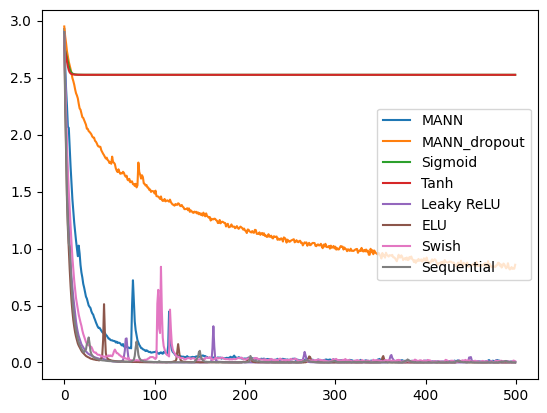

In [23]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')
plt.plot(np.array(range(len(histories['MANN_dropout'].history['loss']))), histories['MANN_dropout'].history['loss'], label='MANN_dropout')
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')
plt.legend()
plt.show()

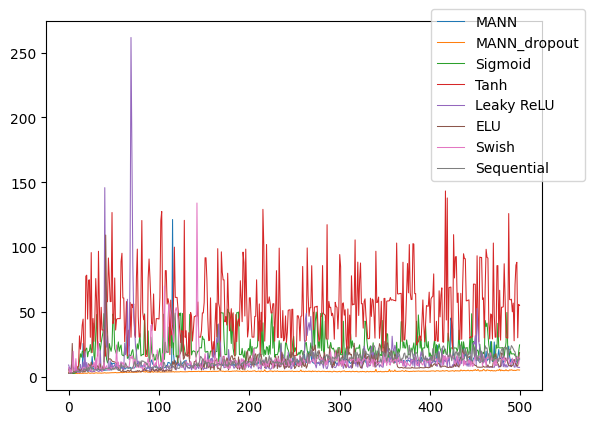

In [24]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_dropout'].history['loss']))), histories['MANN_dropout'].history['val_loss'], label='MANN_dropout', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [28]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('NLP.training_hist.csv')
val_hist_df.to_csv('NLP.validation_hist.csv')

In [10]:
for name, model in models.items():
    model.load_weights(f'NLP.{name}.tf')
    
# Convert to tf-idf for traditional models
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
    
# Traditional Models as a baseline comparison
nb = MultinomialNB()
nb.fit(vectorizer.transform(X_train), one_hot.inverse_transform(y_train).ravel())

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(vectorizer.transform(X_train), one_hot.inverse_transform(y_train).ravel())

LogisticRegression(max_iter=10000)

In [22]:
# Get performance metrics for each model
# Get the testing loss for each model
metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(vectorizer.transform(X_test)).reshape(-1,1)))
log_reg_loss = metric.result().numpy()
metric.update_state(y_test.to_numpy(), one_hot.transform(nb.predict(vectorizer.transform(X_test)).reshape(-1,1)))
nb_loss = metric.result().numpy()
MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_dropout_loss = models['MANN_Dropout'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

49/49 [==============================] - 0s 7ms/step - loss: 2.7325 - categorical_accuracy: 0.0736


In [23]:
# Save metrics to a table and display results
# Save testing loss to table and display results
results = pd.DataFrame([log_reg_loss, nb_loss, MANN_loss, MANN_dropout_loss, Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['Logistic Regression', 'Naive Bayes', 'MANN', 'MANN w/ Dropout', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(10)

,Categorical Accuracy
Logistic Regression,0.264875
Naive Bayes,0.218170
MANN w/ Dropout,0.160589
MANN,0.147153
Leaky ReLU NN,0.130518
Sigmoid NN,0.103647
Swish NN,0.097889
Tanh NN,0.073576
Sequential NN,0.073576
ELU NN,0.043506


In [20]:
# Visual results with confusion matrix
logreg_metrics = classification_report(y_test.to_numpy(), one_hot.transform(log_reg.predict(vectorizer.transform(X_test)).reshape(-1,1)))
nb_metrics = classification_report(y_test.to_numpy(), one_hot.transform(nb.predict(vectorizer.transform(X_test)).reshape(-1,1)))
MANN_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['MANN'].predict(X_test), axis=1), len(one_hot.categories_[0])))
MANN_drop_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['MANN_Dropout'].predict(X_test), axis=1), len(one_hot.categories_[0])))
Sigmoid_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['Sigmoid'].predict(X_test), axis=1), len(one_hot.categories_[0])))
Tanh_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['Tanh'].predict(X_test), axis=1), len(one_hot.categories_[0])))
LeakyReLU_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['LeakyReLU'].predict(X_test), axis=1), len(one_hot.categories_[0])))
ELU_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['ELU'].predict(X_test), axis=1), len(one_hot.categories_[0])))
Swish_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['Swish'].predict(X_test), axis=1), len(one_hot.categories_[0])))
Sequential_metrics = classification_report(y_test.to_numpy(), keras.utils.to_categorical(np.argmax(models['Sequential'].predict(X_test), axis=1), len(one_hot.categories_[0])))

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/49 [========>.....................] - ETA: 0s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 0s 8ms/step


C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/49 [=====>........................] - ETA: 0s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 1/49 [..............................] - ETA: 6s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 1/49 [..............................] - ETA: 4s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 8/49 [===>..........................] - ETA: 0s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/49 [=====>........................] - ETA: 0s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/49 [=====>........................] - ETA: 0s

C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 0s 6ms/step


C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print("Logistic Regression Metrics:")
print(logreg_metrics)
print()

print("Naive Bayes Metrics:")
print(nb_metrics)
print()

print("Multi-Activation Neural Network Metrics:")
print(MANN_metrics)
print()

print("Multi-Activation Neural Network w/ Dropout Metrics:")
print(MANN_drop_metrics)
print()

print("Sigmoid Neural Network Metrics:")
print(Sigmoid_metrics)
print()

print("Tanh Neural Network Metrics:")
print(Tanh_metrics)
print()

print("LeakyReLU Neural Network Metrics:")
print(LeakyReLU_metrics)
print()

print("ELU Neural Network Metrics:")
print(ELU_metrics)
print()

print("Swish Neural Network Metrics:")
print(Swish_metrics)
print()

print("Sequential Neural Network Metrics:")
print(Sequential_metrics)
print()

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11       104
           1       0.36      0.09      0.14       146
           2       1.00      0.02      0.04        56
           3       0.47      0.24      0.32       115
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        20
           8       0.24      0.52      0.33       212
           9       0.23      0.67      0.34       257
          10       0.33      0.28      0.30       156
          11       0.33      0.20      0.25       162
          12       0.67      0.03      0.05        73
          13       0.00      0.00      0.00        73
          14       0.00      0.00      0.00        52
          15       1.00      0.05      0.09        65

   micro avg       0.26      0.26      0.26      15